Sphere synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/spheref.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Sphere'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Sphere':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -5.12 
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * ( x1_training ** 2
                            + x2_training ** 2
                            )
  

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y \t GP EI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def acqfuncApproxMeanTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = df1 + df2

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApproxMeanTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncApprox_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncApprox_exploit)
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        min_acqfuncApprox_exploit = self.min_acqfuncApprox_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
            min_acqfuncApprox_exploit = BOLD + OKGREEN + str(min_acqfuncApprox_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox, min_acqfuncApprox_exploit))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP dEI: maximum y \t GP dEI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncExactExploitTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = -(df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return -f, np.asarray(df_arr).transpose()

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExactExploitTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncExact_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncExact_exploit)
            
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        min_acqfuncExact_exploit = self.min_acqfuncExact_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
            min_acqfuncExact_exploit = BOLD + OKGREEN + str(min_acqfuncExact_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact, min_acqfuncExact_exploit))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 1.5925778782479172	 0.9415089350695705
2  	 [5.12 5.12]	 52.4288	 1.275455677703416	 1.5925778776207775	 0.9415089342660553
3  	 [-5.12  5.12]	 52.4288	 1.275455677703416	 1.5925740218285798	 0.9415039940815388
4  	 [3.42250321 0.51119867]	 11.974852281651728	 1.275455677703416	 1.5922785146675416	 0.9411253859984825
5  	 [ 0.4376922  -2.49216761]	 6.40247388006668	 1.275455677703416	 1.5826945371458223	 0.9288542551429

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 1.1945155933603315	 0.4436751738637678
2  	 [ 4.81417587 -3.13615063]	 33.01173008164121	 0.6972563370202991	 1.19451434962462	 0.44367412742043094
3  	 [-0.00653243  5.12      ]	 26.214442672594636	 0.6972563370202991	 1.1944864861929108	 0.4436400802981407
4  	 [-5.12  5.12]	 52.4288	 0.6972563370202991	 1.194309676187235	 0.4434269091492371
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 1.193528218493978	 0.4424

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 4.62594968 -1.72716685]	 24.382515760418432	 4.59675431006429	 4.604111320765137	 4.5472456103503776
2  	 [-4.57811421  5.09191652]	 46.88674355303911	 4.59675431006429	 4.604110931072832	 4.547244969236273
3  	 [ 0.82883316 -5.12      ]	 26.90136441051294	 4.59675431006429	 4.604061110846	 4.54719186330312
4  	 [-0.44145971  5.12      ]	 26.409286677630373	 4.59675431006429	 4.582033649432143	 4.523696179474192
5	 [ 0.82827233 -1.27984998]	 2.3240510288035345	 2.3240510288035345	 4.5715265081

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-5.12        4.14099457]	 43.36223602290998	 6.844040613967918	 6.844198530978562	 6.8419124884221345
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 6.844193745735943	 6.841907610624128
3  	 [0.31011482 5.12      ]	 26.310571200528994	 6.844040613967918	 6.8441879641995556	 6.841901806356957
4  	 [-0.95718136 -5.12      ]	 27.1305961538866	 6.844040613967918	 6.833287557187282	 6.830958385845417
5	 [0.70230377 1.02858908]	 1.5512260872011265	 1.5512260872011265	 6.832515171849922	 6.830182

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 1.6281597426122008	 0.9871539390661513
2  	 [5.12       5.01238555]	 51.33840892332317	 1.3234068721819314	 1.6281590084630853	 0.9871537251005541
3  	 [-5.12       -0.04786458]	 26.216691018425248	 1.3234068721819314	 1.6274860861078573	 0.9862887695293819
4  	 [0.96524419 5.12      ]	 27.14609634009872	 1.3234068721819314	 1.6210814251494714	 0.9780651847732398
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 1.6

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [4.11965622 5.12      ]	 43.18596737725548	 0.7844720799352826	 1.2507225569805602	 0.5119135320864208
2  	 [-5.12 -5.12]	 52.4288	 0.7844720799352826	 1.250722531315433	 0.5119126375100809
3  	 [-5.12  5.12]	 52.4288	 0.7844720799352826	 1.2501641658874603	 0.5112312614230425
4  	 [-0.44948625  5.12      ]	 26.416437893103673	 0.7844720799352826	 1.24965964240629	 0.5106148323978008
5  	 [-0.92587221 -4.00794354]	 16.92085080283722	 0.7844720799352826	 1.247417583134826	 0.50787

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 5.623970530540822	 5.6086316033538575
2  	 [ 5.12 -5.12]	 52.4288	 5.622519010932044	 5.623965991173253	 5.608626965871545
3  	 [3.32677936 5.12      ]	 37.28186092483975	 5.622519010932044	 5.623914822676422	 5.608574691326565
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 5.6239846283798745	 5.608646005902745
5	 [ 1.22341687 -0.77267839]	 2.0937807397208346	 2.0937807397208346	 5.60266915498386	 5.58686380528022

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [-4.36608793e-04  2.06674367e+00]	 4.271429598672614	 0.10287109474532606	 0.8513709009566058	 0.05568315813121624
2  	 [-5.12  5.12]	 52.4288	 0.10287109474532606	 0.8503753017804847	 0.05354430505382158
3  	 [ 4.04653495 -5.12      ]	 42.5888451205719	 0.10287109474532606	 0.8503739366088535	 0.05354383742243646
4  	 [-5.12       -0.23607549]	 26.270131638470147	 0.10287109474532606	 0.8503427325439412	 0.05351162787045145
5  	 [-0.8721827  5.12     ]	 26.975102668941314	 0.

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.69491889 4.82146316]	 36.89893267190826	 7.349882113053805	 7.349939623433926	 7.349007818560137
2  	 [-2.28325892  5.12      ]	 31.42767130669173	 7.349882113053805	 7.34993868320942	 7.349006877054278
3  	 [ 4.85377973 -0.96421613]	 24.488890382834978	 7.349882113053805	 7.34993821075366	 7.349006308195186
4	 [0.53602364 1.34185879]	 2.0879063532673254	 2.0879063532673254	 7.3488930525708644	 7.347959454046378
5  	 [ 4.2514357 -5.12     ]	 44.28910548315764	 2.0879063532673254	 2

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928502	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928502	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928502	 7.941821858928502	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928502	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928502	    	    
1  	 [ 5.12       -0.36519675]	 26.34776866881902	 7.941821858928502	 7.941751005907399	 7.94145039245874
2  	 [5.12 5.12]	 52.4288	 7.941821858928502	 7.941699776954361	 7.941399132857056
3  	 [-5.12       -0.59618732]	 26.569839315034457	 7.941821858928502	 7.931984859739914	 7.931678364187649
4  	 [-0.58314756  5.12      ]	 26.55446107177098	 7.941821858928502	 7.901342604986324	 7.901016968541047
5  	 [-5.12  5.12]	 52.4288	 7.941821858928502	 7.888766806660171	 7.888432989872011
6	 [-0.915

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 1.1898686681311723	 0.4380758157391548
2  	 [-5.12  5.12]	 52.4288	 0.6899456214148796	 1.189860132757955	 0.43806553720219416
3  	 [ 5.12       -0.71940695]	 26.731946353325895	 0.6899456214148796	 1.1881163372713106	 0.43596609426325145
4  	 [0.92473097 5.12      ]	 27.06952737499057	 0.6899456214148796	 1.17087177720776	 0.41224162844442735
5  	 [-0.19961111 -2.46512035]	 6.1166629526971885	 0.6899456214148796	 1.1

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 5.994237365089377	 5.985286390941009
2  	 [-4.15109266 -5.12      ]	 43.44597023451905	 5.993464196233534	 5.994237163434248	 5.985286091867031
3	 [2.28117334 0.77905251]	 5.810674613708926	 5.810674613708926	 5.99412775693692	 5.98517530978402
4  	 [0.22734929 5.12      ]	 26.266087701518654	 5.810674613708926	 5.811320510228786	 5.799591334041033
5  	 [-0.05693962 -3.03366024]	 9.206336598212415	 5.810674613708926	 5.809714302958114	 5.797957683

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 7.271568186175726	 7.270492860134739
2  	 [-5.12       2.9827349]	 35.111107491263496	 7.271500601275535	 7.271566998042995	 7.270491787133205
3  	 [-0.59462664 -5.12      ]	 26.567980840484395	 7.271500601275535	 7.269457950858464	 7.268378491867869
4  	 [-1.67014801  5.12      ]	 29.003794380347195	 7.271500601275535	 7.2612291789022745	 7.26013346753254
5	 [-0.68837786 -0.62671511]	 0.8666359153539505	 0.8666359153539505	 7.

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.12 -5.12]	 52.4288	 3.480496204392171	 3.513633268751706	 3.338116184053161
2  	 [5.10055263 5.12      ]	 52.23003717223822	 3.480496204392171	 3.5136322123647155	 3.33811579770714
3  	 [-5.12        0.39374029]	 26.369431412772123	 3.480496204392171	 3.513618757181146	 3.338100079468772
4  	 [ 5.12       -0.07494469]	 26.220016706989426	 3.480496204392171	 3.513561437643989	 3.3380336323270807
5	 [-1.58751435  0.05051817]	 2.522753899086134	 2.522753899086134	 3.443790162056067	 3.2

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [2.7754098  2.98802689]	 16.631204280641075	 5.383887924980681	 5.38606446985145	 5.364764980253465
2  	 [-5.12        4.81945146]	 49.44151236323329	 5.383887924980681	 5.38606287832432	 5.364764167045988
3  	 [-0.72303187  5.12      ]	 26.737175089392025	 5.383887924980681	 5.382688333805508	 5.361291519615836
4  	 [-0.11962742 -5.12      ]	 26.22871072080369	 5.383887924980681	 5.3791052722500705	 5.357604786667492
5  	 [5.12       0.18688128]	 26.249324613482322	 5.383887924980681	

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [2.23926683 5.12      ]	 31.228715941011302	 8.084978900492077	 8.084990713563913	 8.084765093768835
2  	 [5.12       0.62055316]	 26.599486219627295	 8.084978900492077	 8.08496973437256	 8.084744102465299
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 8.084598853373462	 8.084373053091934
4	 [0.93966402 0.94350446]	 1.7731691309347872	 1.7731691309347872	 8.078810270013056	 8.078581813544385
5  	 [ 5.12 -5.12]	 52.4288	 1.7731691309347872	 1.970311806386343	 1.381269673695219
6  	 [-0

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 2.6751832097646906	 2.328518566309753
2  	 [-4.96030997  4.71854675]	 46.869358421617264	 2.5824114132885994	 2.675181104396316	 2.3285170210082384
3  	 [0.0054658 5.12     ]	 26.214429874925216	 2.5824114132885994	 2.6749388341604416	 2.328213531051416
4  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 2.674214638086261	 2.3273095434919395
5  	 [ 0.85280561 -2.81524164]	 8.652862906314947	 2.5824114132885994	 2.6718077692

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 2.489407676741919	 2.0950100002294367
2  	 [-5.12       -1.45227108]	 28.3234912830853	 2.3742017032787373	 2.4869963987778716	 2.0919587845015335
3  	 [-1.15623557  1.83903844]	 4.7189430902825364	 2.3742017032787373	 2.4773965068655976	 2.0798100822010106
4  	 [-2.03883017  5.12      ]	 30.371228446245972	 2.3742017032787373	 2.4558521427956714	 2.052506447305444
5  	 [-0.98972163 -1.46068201]	 3.1131408269185528	 2.

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.75309484 -5.12      ]	 48.80631052939498	 12.957869519084127	 12.957869496486827	 12.957869495872123
2	 [ 1.50914555 -1.41207467]	 4.271475151684537	 4.271475151684537	 12.955950197051237	 12.955950196437698
3  	 [5.12 5.12]	 52.4288	 4.271475151684537	 4.2678972268952045	 4.184979410663627
4  	 [-5.12       -1.05768757]	 27.33310300391219	 4.271475151684537	 4.266851226573325	 4.183839571118322
5  	 [-1.25757868  5.12      ]	 27.79590413758324	 4.271475151684537	 4.263894782280

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.56773338 -5.12      ]	 38.94312144661133	 1.579257056101869	 1.8240962518239396	 1.239916849675231
2  	 [ 5.12 -5.12]	 52.4288	 1.579257056101869	 1.8226209041327182	 1.2380082982118865
3  	 [ 5.12       -0.75178149]	 26.77957540342997	 1.579257056101869	 1.8200109105974476	 1.2346317231622403
4  	 [-2.73894187  5.12      ]	 33.71620254132422	 1.579257056101869	 1.8095487771140286	 1.2210984227970703
5  	 [-5.12       -1.69354954]	 29.08251005768972	 1.579257056101869	 1.799094941578749

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 1.5925778782479172	 0.9415089350695705
2  	 [5.12       3.36783542]	 37.55671539878192	 1.275455677703416	 1.592577857354429	 0.9415089342660553
3  	 [ 2.40146578 -0.17378187]	 5.797238022053689	 1.275455677703416	 1.5899887414526428	 0.9381921918609035
4  	 [-5.12        4.36680096]	 45.28335059684448	 1.275455677703416	 1.592552727046903	 0.9414595857950274
5  	 [1.30762101 5.12      ]	 27.924272700727766	 1.2754556

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [5.12 5.12]	 52.4288	 0.6972563370202991	 1.1945156055900972	 0.4436751886090398
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 1.1945141517615334	 0.4436734357467859
3  	 [-0.14724304  5.12      ]	 26.236080513371153	 0.6972563370202991	 1.194472843498889	 0.4436236556706414
4  	 [4.19814932 0.55652488]	 17.934177627777412	 0.6972563370202991	 1.1937448998515563	 0.4425406853137387
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 1.1935282244680223	 0.4

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 2.87036899 -1.98289163]	 12.170877343622498	 4.59675431006429	 4.604079794844259	 4.547211778519575
2  	 [-3.33114862  5.05305125]	 36.62987805318713	 4.59675431006429	 4.6040867880204726	 4.547212895078585
3  	 [-0.40701955 -2.40839967]	 5.966053860772153	 4.59675431006429	 4.53181634231452	 4.457362704015301
4  	 [ 1.47776527 -5.12      ]	 28.398190192382167	 4.59675431006429	 4.574993886896152	 4.507470590247765
5  	 [5.12       0.52669006]	 26.491802422845403	 4.59675431006429	 4.5662788

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-1.14334581  4.64643194]	 22.896569443900606	 6.844040613967918	 6.844198691403709	 6.841913216829061
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 6.844193745732506	 6.841907610620677
3  	 [-0.95819369 -5.12      ]	 27.132535153656406	 6.844040613967918	 6.833287493862271	 6.830958329422577
4	 [0.65712638 1.17928828]	 1.8225359163068036	 1.8225359163068036	 6.831378150964439	 6.829013763433246
5  	 [-5.12        2.45166061]	 32.22503973412286	 1.8225359163068036	 2.0182197598880456	 1.

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 1.6281597426122008	 0.9871539390661513
2  	 [5.12 5.12]	 52.4288	 1.3234068721819314	 1.6281595760134915	 0.9871537251005541
3  	 [-5.12       -0.27719042]	 26.29123452807068	 1.3234068721819314	 1.6272897908789583	 0.9779406496644019
4  	 [0.99551455 5.11914473]	 27.1966919681028	 1.3234068721819314	 1.620924980517749	 0.9759208448157075
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	 1.6196491999775522	 0.9762

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [5.12 5.12]	 52.4288	 0.7844720799352826	 1.250722557209966	 0.5119135942328988
2  	 [-3.74535283 -5.12      ]	 40.24206779776266	 0.7844720799352826	 1.2507225040704095	 0.5119098587919962
3  	 [0.08402923 5.12      ]	 26.221460911676587	 0.7844720799352826	 1.2505187585884068	 0.5116072231754802
4  	 [2.56669879 1.74876145]	 9.646109280504115	 0.7844720799352826	 1.241133012953653	 0.4871563373244379
5  	 [-0.25046164 -3.54643381]	 12.639923790732329	 0.7844720799352826	 1.22

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 5.623970530540822	 5.608615162487226
2  	 [3.33590081 5.12      ]	 37.342634208733344	 5.622519010932044	 5.623914820132658	 5.608525302580072
3  	 [ 4.5235682  -4.16736717]	 37.82961837123037	 5.622519010932044	 5.623289213108925	 5.60547611667791
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 5.6239846283798745	 5.608646005902745
5	 [ 1.20807972 -0.75572559]	 2.0305777820257194	 2.0305777820257194	 5.602413738

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [0.02041459 1.98577863]	 3.943733542072024	 0.10287109474532606	 0.8513248707571486	 0.05354199656417228
2  	 [-5.03492225  2.95509263]	 34.08301446412634	 0.10287109474532606	 0.8503734940757717	 0.053543606186713916
3  	 [-5.12       -1.47896116]	 28.40172612269111	 0.10287109474532606	 0.8488848361561557	 0.04947922775175452
4  	 [ 2.57855628 -4.69210849]	 28.66483461803054	 0.10287109474532606	 0.8503612250776876	 0.053210114028132936
5  	 [0.12155999 4.9809562 ]	 24.824

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [4.68664599 5.12      ]	 48.179050673140004	 7.349882113053805	 7.349939623433926	 7.349007818560137
2  	 [ 4.93512605 -1.14868802]	 25.674953297624498	 7.349882113053805	 7.349938575846465	 7.3490070308653115
3  	 [-1.47922339  4.44879978]	 21.979921333163915	 7.349882113053805	 7.349938263911135	 7.3490067119998095
4	 [1.09349406 1.13408365]	 2.4818749979390615	 2.4818749979390615	 7.347285794193946	 7.3463494344518585
5  	 [3.50678683 1.84048058]	 15.68492261118841	 2.48187499793

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928502	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928502	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928502	 7.941821858928502	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928502	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928502	    	    
1  	 [ 5.12       -0.34675903]	 26.33464182441566	 7.941821858928502	 7.9417508463914555	 7.941450308236735
2  	 [5.12 5.12]	 52.4288	 7.941821858928502	 7.941699369416505	 7.941398725075929
3  	 [-4.21705607 -0.7275049 ]	 18.31282532366967	 7.941821858928502	 7.904211561858476	 7.9038855795947915
4  	 [0.65867346 5.11113959]	 26.5575986246983	 7.941821858928502	 7.818599464701569	 7.820178297597392
5	 [ 0.09877078 -0.03903922]	 0.011279726611796322	 0.011279726611796322	 7.794630075339412	 7

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 1.1898686681311723	 0.4380758157391548
2  	 [ 4.94072018 -0.61728397]	 24.791755402212313	 0.6899456214148796	 1.1875807721510645	 0.4353214183633416
3  	 [-1.19896852  5.12      ]	 27.651925507645664	 0.6899456214148796	 1.1666838274617444	 0.4102648605865108
4  	 [ 1.19392454 -1.30462948]	 3.1275138631117585	 0.6899456214148796	 1.1596509704568805	 0.4020820282722089
5  	 [-3.74685469  2.91006244]	 22.507383479647

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12       4.28576605]	 44.58219063385849	 5.993464196233534	 5.994237365089219	 5.985286390941009
2  	 [-5.12       -4.85983818]	 49.83242712805688	 5.993464196233534	 5.994237270309308	 5.985285453345221
3  	 [0.29710703 5.12      ]	 26.30267258716383	 5.993464196233534	 5.993927587379909	 5.9849607317639215
4	 [1.89092034 0.56120834]	 3.8905345163315044	 3.8905345163315044	 5.993730915116168	 5.98435608952832
5  	 [-0.44602232 -4.06809875]	 16.748363342391862	 3.8905345163315044	 3

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.18648609 -2.4678052 ]	 23.616728302103265	 7.271500601275535	 7.271568186278327	 7.270492860134739
2  	 [-3.79946932  2.66821301]	 21.55532775288146	 7.271500601275535	 7.271525357105591	 7.270449947327427
3  	 [-0.69739246 -5.12      ]	 26.700756242868632	 7.271500601275535	 7.270026503494135	 7.268948722985995
4	 [-0.58669696 -0.75006876]	 0.9068164551257099	 0.9068164551257099	 7.258896672486266	 7.25776109555372
5  	 [-0.94715615  5.12      ]	 27.111504777750348	 0.9068164551257099	

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-5.12       -0.19377072]	 26.25194709281843	 3.480496204392171	 3.5136325940103443	 3.33811395516163
2  	 [5.12 5.12]	 52.4288	 3.480496204392171	 3.5136323163824983	 3.3381157977071623
3  	 [-4.34551125 -5.12      ]	 45.09786803255743	 3.480496204392171	 3.5135793432928555	 3.3379668905927016
4  	 [ 5.12       -0.05216576]	 26.21712126687544	 3.480496204392171	 3.5135608281387327	 3.337979726055551
5	 [-1.73473933  0.36160505]	 3.140078760998255	 3.140078760998255	 3.4352358813281243

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [5.12       4.67669476]	 48.08587386986069	 5.383887924980681	 5.386064667626315	 5.364765183718506
2  	 [-0.5836373  5.12     ]	 26.555032493543965	 5.383887924980681	 5.386057491871865	 5.364743411528607
3  	 [-5.12        3.54942235]	 38.81279901094424	 5.383887924980681	 5.385656207278279	 5.363693220435916
4  	 [2.58493343 0.8618431 ]	 7.42465433620531	 5.383887924980681	 5.384058792111845	 5.362621504695591
5  	 [-0.98214977 -5.12      ]	 27.17901817882703	 5.383887924980681	 5

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [3.27469422 5.12      ]	 36.93802224021954	 8.084978900492077	 8.084990718072902	 8.084765096566837
2  	 [5.12       0.30279176]	 26.30608285158056	 8.084978900492077	 8.084921598492175	 8.084695866193675
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 8.084598853372793	 8.084373053091264
4	 [0.90509598 1.39472461]	 2.7644554690851795	 2.7644554690851795	 8.0809249111166	 8.080697359991731
5  	 [-0.22984736  3.68951112]	 13.665322149736932	 2.7644554690851795	 2.7775076338434554	 2.4

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 2.6751832097646906	 2.328518566309753
2  	 [-1.21990793  5.12      ]	 27.70257535209655	 2.5824114132885994	 2.6751668747334127	 2.3284017541156663
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 2.67423926333734	 2.327340283293416
4  	 [ 0.90891898 -3.03876689]	 10.060237903108394	 2.5824114132885994	 2.6713887357979926	 2.293670898152037
5  	 [-4.82762476  2.72283122]	 30.719770625377336	 2.5824114132885994	 2.66969

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 2.489407676741919	 2.0950100002294367
2  	 [-2.20660477 -0.45183714]	 5.073261429346723	 2.3742017032787373	 2.4867349492798945	 2.0914950138416426
3  	 [-1.33223764  2.98566968]	 10.689080551059877	 2.3742017032787373	 2.451496800344446	 2.0469146044376703
4  	 [-5.12      -1.9319886]	 29.946979952812764	 2.3742017032787373	 2.472466381686154	 2.040228200426281
5  	 [ 0.17835775 -2.37604674]	 5.677409592475777	 2.37

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.82668731 -3.73098301]	 37.21714456946748	 12.957869519084127	 12.957842947554632	 12.957842946941906
2	 [-0.64696019 -0.05249445]	 0.4213131500748724	 0.4213131500748724	 12.952859473608974	 12.95285947299754
3  	 [5.12 5.12]	 52.4288	 0.4213131500748724	 1.0171312288936203	 0.2354998550138635
4  	 [-5.12       -1.17676652]	 27.599179438918725	 0.4213131500748724	 1.0159262785670076	 0.23249487543809205
5  	 [ 1.49625134 -0.9344517 ]	 3.111968058662604	 0.4213131500748724	 1.0

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.59633469 -5.12      ]	 39.1480231675953	 1.579257056101869	 1.8240963904605108	 1.2399183345336837
2  	 [ 5.12       -1.04833609]	 27.313408558419926	 1.579257056101869	 1.8223127630306013	 1.237561691858708
3  	 [-2.35021732  4.6689615 ]	 27.322722964184308	 1.579257056101869	 1.7806827280969495	 1.1837071461292823
4  	 [-3.87977034 -1.48779248]	 17.266144365339457	 1.579257056101869	 1.7811368477317673	 1.1010064238394193
5  	 [1.79013693 0.16049596]	 3.2303491925659467	 1.579257056

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-2.691702328576687, -4.193036367682318)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-2.7118399172202, -4.326287391135164)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-4.36082570159807, -3.3716348667067533)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-2.5442862753741444, -3.4798091404251115)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-3.7485719317900474, -3.027565175434435)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-3.1851608210732083, -2.471962941011188)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-4.380699507816262, -4.6151548390674915)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-3.160270096996454, -5.961153403862587)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-4.067900609062852, -1.8654220526320773)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-5.934469711083021, -4.484748269748813)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-3.4752848161423024, -7.209562772302787)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-2.4131136622083385, -2.423356944231762)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-3.3995948634694217, -5.816855822016586)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-5.9348446363583625, -6.607463114879785)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-4.916488277258566, -7.983957903641856)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-2.5877720081218216, -1.5278968438114962)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-2.917575296759416, -4.031355336767628)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-3.3811023863169853, -3.9006548372236)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-7.489050612058152, -2.9794320496309776)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(-3.9643393519829235, -5.129465359422259)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def extractAcqFuncMax(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-3]
    return new_array

def exploitExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-3]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-3] * -1
    return new_array


In [97]:
approx1_acqFuncMax = extractAcqFuncMax(approx_1.history) + eps
approx1_exploit = exploitExtract(approx_1.history) + eps
approx1_ratio = approx1_exploit/approx1_acqFuncMax 

np.round(approx1_acqFuncMax, 3), np.round(approx1_exploit,3)


(array([1.593, 1.593, 1.593, 1.592, 1.583, 1.582, 1.538, 1.513, 1.315,
        1.317, 0.811, 0.738, 0.705, 0.554, 0.557, 0.554, 0.556, 0.549,
        0.544, 0.546]),
 array([0.942, 0.942, 0.942, 0.941, 0.929, 0.928, 0.872, 0.84 , 0.597,
        0.601, 0.013, 0.013, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [98]:
approx2_acqFuncMax = extractAcqFuncMax(approx_2.history) + eps
approx2_exploit = exploitExtract(approx_2.history) + eps
approx2_ratio = approx2_exploit/approx2_acqFuncMax

np.round(approx2_acqFuncMax, 3), np.round(approx2_exploit, 3)


(array([1.195, 1.195, 1.194, 1.194, 1.194, 1.166, 1.154, 1.119, 1.038,
        0.988, 0.968, 0.873, 0.848, 0.566, 0.565, 0.561, 0.559, 0.559,
        0.559, 0.559]),
 array([0.444, 0.444, 0.444, 0.443, 0.442, 0.418, 0.395, 0.354, 0.26 ,
        0.203, 0.076, 0.075, 0.102, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [99]:
approx3_acqFuncMax = extractAcqFuncMax(approx_3.history) + eps
approx3_exploit = exploitExtract(approx_3.history) + eps
approx3_ratio = approx3_exploit/approx3_acqFuncMax

np.round(approx3_acqFuncMax, 3), np.round(approx3_exploit, 3)


(array([4.604, 4.604, 4.604, 4.582, 4.572, 2.414, 2.253, 2.197, 2.121,
        2.035, 1.96 , 1.89 , 1.848, 1.791, 1.855, 0.527, 0.536, 0.543,
        0.547, 0.55 ]),
 array([4.547, 4.547, 4.547, 4.524, 4.512, 2.   , 1.794, 1.723, 1.627,
        1.206, 1.325, 1.325, 1.209, 1.209, 1.301, 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [100]:
approx4_acqFuncMax = extractAcqFuncMax(approx_4.history) + eps
approx4_exploit = exploitExtract(approx_4.history) + eps
approx4_ratio = approx4_exploit/approx4_acqFuncMax

np.round(approx4_acqFuncMax, 3), np.round(approx4_exploit, 3)


(array([6.844, 6.844, 6.844, 6.833, 6.833, 1.734, 1.727, 1.697, 1.552,
        0.935, 0.905, 0.895, 0.824, 0.545, 0.55 , 0.553, 0.554, 0.555,
        0.556, 0.557]),
 array([6.842, 6.842, 6.842, 6.831, 6.83 , 1.124, 1.115, 1.037, 0.892,
        0.141, 0.168, 0.121, 0.085, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [101]:
approx5_acqFuncMax = extractAcqFuncMax(approx_5.history) + eps
approx5_exploit = exploitExtract(approx_5.history) + eps
approx5_ratio = approx5_exploit/approx5_acqFuncMax

np.round(approx5_acqFuncMax, 3), np.round(approx5_exploit, 3)


(array([1.628, 1.628, 1.627, 1.621, 1.62 , 1.589, 1.572, 1.504, 1.482,
        1.44 , 1.299, 1.247, 1.036, 0.483, 0.506, 0.518, 0.526, 0.532,
        0.536, 0.539]),
 array([0.987, 0.987, 0.986, 0.978, 0.976, 0.937, 0.915, 0.828, 0.804,
        0.586, 0.587, 0.24 , 0.298, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [102]:
approx6_acqFuncMax = extractAcqFuncMax(approx_6.history) + eps
approx6_exploit = exploitExtract(approx_6.history) + eps
approx6_ratio = approx6_exploit/approx6_acqFuncMax

np.round(approx6_acqFuncMax, 3), np.round(approx6_exploit, 3)


(array([1.251, 1.251, 1.25 , 1.25 , 1.247, 1.239, 1.205, 1.133, 0.979,
        0.935, 0.845, 0.528, 0.537, 0.542, 0.546, 0.548, 0.55 , 0.552,
        0.553, 0.554]),
 array([0.512, 0.512, 0.511, 0.511, 0.508, 0.498, 0.37 , 0.37 , 0.231,
        0.192, 0.119, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [103]:
approx7_acqFuncMax = extractAcqFuncMax(approx_7.history) + eps
approx7_exploit = exploitExtract(approx_7.history) + eps
approx7_ratio = approx7_exploit/approx7_acqFuncMax

np.round(approx7_acqFuncMax, 3), np.round(approx7_exploit, 3)


(array([5.624, 5.624, 5.624, 5.624, 5.603, 2.202, 2.097, 2.081, 1.891,
        1.621, 1.61 , 1.611, 1.514, 0.477, 0.502, 0.516, 0.524, 0.53 ,
        0.534, 0.537]),
 array([5.609, 5.609, 5.609, 5.609, 5.587, 1.729, 1.594, 1.572, 1.332,
        0.978, 0.965, 0.965, 0.868, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [104]:
approx8_acqFuncMax = extractAcqFuncMax(approx_8.history) + eps
approx8_exploit = exploitExtract(approx_8.history) + eps
approx8_ratio = approx8_exploit/approx8_acqFuncMax

np.round(approx8_acqFuncMax, 3), np.round(approx8_exploit, 3)


(array([0.851, 0.85 , 0.85 , 0.85 , 0.841, 0.828, 0.779, 0.711, 0.689,
        0.683, 0.559, 0.671, 0.546, 0.544, 0.537, 0.538, 0.54 , 0.542,
        0.544, 0.546]),
 array([ 0.056,  0.054,  0.054,  0.054,  0.044,  0.03 ,  0.   ,  0.   ,
         0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [105]:
approx9_acqFuncMax = extractAcqFuncMax(approx_9.history) + eps
approx9_exploit = exploitExtract(approx_9.history) + eps
approx9_ratio = approx9_exploit/approx9_acqFuncMax

np.round(approx9_acqFuncMax, 3), np.round(approx9_exploit, 3)


(array([7.35 , 7.35 , 7.35 , 7.349, 2.239, 2.155, 2.138, 2.104, 2.049,
        2.014, 2.008, 1.724, 1.677, 1.707, 0.591, 0.578, 0.57 , 0.554,
        0.488, 0.503]),
 array([7.349, 7.349, 7.349, 7.348, 1.776, 1.667, 1.647, 1.602, 1.531,
        1.486, 1.479, 1.057, 1.055, 1.097, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [106]:
approx10_acqFuncMax = extractAcqFuncMax(approx_10.history) + eps
approx10_exploit = exploitExtract(approx_10.history) + eps
approx10_ratio = approx10_exploit/approx10_acqFuncMax

np.round(approx10_acqFuncMax, 3), np.round(approx10_exploit, 3)


(array([7.942, 7.942, 7.932, 7.901, 7.889, 7.859, 1.197, 1.067, 1.008,
        1.004, 0.977, 0.948, 0.836, 0.776, 0.47 , 0.495, 0.509, 0.519,
        0.526, 0.531]),
 array([7.941, 7.941, 7.932, 7.901, 7.888, 7.859, 0.447, 0.312, 0.245,
        0.245, 0.245, 0.158, 0.056, 0.057, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [107]:
approx11_acqFuncMax = extractAcqFuncMax(approx_11.history) + eps
approx11_exploit = exploitExtract(approx_11.history) + eps
approx11_ratio = approx11_exploit/approx11_acqFuncMax

np.round(approx11_acqFuncMax, 3), np.round(approx11_exploit, 3)


(array([1.19 , 1.19 , 1.188, 1.171, 1.168, 1.139, 1.053, 1.017, 0.962,
        0.889, 0.802, 0.801, 0.823, 0.769, 0.511, 0.523, 0.532, 0.537,
        0.541, 0.544]),
 array([0.438, 0.438, 0.436, 0.412, 0.412, 0.377, 0.277, 0.235, 0.191,
        0.095, 0.007, 0.045, 0.043, 0.044, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [108]:
approx12_acqFuncMax = extractAcqFuncMax(approx_12.history) + eps
approx12_exploit = exploitExtract(approx_12.history) + eps
approx12_ratio = approx12_exploit/approx12_acqFuncMax

np.round(approx12_acqFuncMax, 3), np.round(approx12_exploit, 3)


(array([5.994, 5.994, 5.994, 5.811, 5.81 , 5.782, 5.762, 5.583, 2.991,
        2.982, 2.969, 2.851, 2.776, 0.559, 0.561, 0.562, 0.562, 0.563,
        0.563, 0.563]),
 array([5.985, 5.985, 5.985, 5.8  , 5.798, 5.77 , 5.75 , 5.567, 2.719,
        2.707, 2.691, 2.547, 2.456, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [109]:
approx13_acqFuncMax = extractAcqFuncMax(approx_13.history) + eps
approx13_exploit = exploitExtract(approx_13.history) + eps
approx13_ratio = approx13_exploit/approx13_acqFuncMax

np.round(approx13_acqFuncMax, 3), np.round(approx13_exploit, 3)


(array([7.272, 7.272, 7.269, 7.261, 7.259, 1.285, 1.253, 1.134, 1.112,
        1.112, 1.061, 1.023, 0.887, 0.844, 0.503, 0.518, 0.527, 0.532,
        0.536, 0.54 ]),
 array([ 7.27 ,  7.27 ,  7.268,  7.26 ,  7.258,  0.515,  0.515,  0.383,
         0.37 ,  0.238,  0.286,  0.157,  0.   ,  0.119, -0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [110]:
approx14_acqFuncMax = extractAcqFuncMax(approx_14.history) + eps
approx14_exploit = exploitExtract(approx_14.history) + eps
approx14_ratio = approx14_exploit/approx14_acqFuncMax

np.round(approx14_acqFuncMax, 3), np.round(approx14_exploit, 3)


(array([3.514, 3.514, 3.514, 3.514, 3.444, 2.553, 2.544, 2.518, 2.473,
        2.452, 2.311, 2.197, 2.136, 1.967, 0.509, 0.526, 0.535, 0.54 ,
        0.544, 0.547]),
 array([3.338, 3.338, 3.338, 3.338, 3.257, 2.132, 2.164, 2.131, 2.048,
        2.048, 1.868, 1.723, 1.647, 1.447, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [111]:
approx15_acqFuncMax = extractAcqFuncMax(approx_15.history) + eps
approx15_exploit = exploitExtract(approx_15.history) + eps
approx15_ratio = approx15_exploit/approx15_acqFuncMax

np.round(approx15_acqFuncMax, 3), np.round(approx15_exploit, 3)


(array([5.386, 5.386, 5.383, 5.379, 5.367, 5.354, 1.566, 1.472, 1.452,
        1.434, 1.332, 1.19 , 1.186, 1.152, 1.009, 0.479, 0.503, 0.516,
        0.524, 0.53 ]),
 array([5.365, 5.365, 5.361, 5.358, 5.345, 5.332, 0.762, 0.788, 0.763,
        0.622, 0.622, 0.481, 0.434, 0.262, 0.262, 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [112]:
approx16_acqFuncMax = extractAcqFuncMax(approx_16.history) + eps
approx16_exploit = exploitExtract(approx_16.history) + eps
approx16_ratio = approx16_exploit/approx16_acqFuncMax

np.round(approx16_acqFuncMax, 3), np.round(approx16_exploit, 3)


(array([8.085, 8.085, 8.085, 8.079, 1.97 , 1.933, 1.895, 1.839, 1.728,
        1.618, 1.582, 1.666, 0.611, 0.596, 0.59 , 0.584, 0.576, 0.572,
        0.571, 0.57 ]),
 array([8.085, 8.085, 8.084, 8.079, 1.381, 1.381, 1.332, 1.259, 1.121,
        0.974, 0.938, 1.049, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [113]:
approx17_acqFuncMax = extractAcqFuncMax(approx_17.history) + eps
approx17_exploit = exploitExtract(approx_17.history) + eps
approx17_ratio = approx17_exploit/approx17_acqFuncMax

np.round(approx17_acqFuncMax, 3), np.round(approx17_exploit, 3)


(array([2.675, 2.675, 2.675, 2.674, 2.672, 2.625, 2.447, 2.421, 2.396,
        2.269, 0.616, 0.592, 0.577, 0.562, 0.549, 0.549, 0.552, 0.551,
        0.534, 0.536]),
 array([2.329, 2.329, 2.328, 2.327, 2.324, 2.266, 2.042, 2.009, 1.976,
        1.823, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [114]:
approx18_acqFuncMax = extractAcqFuncMax(approx_18.history) + eps
approx18_exploit = exploitExtract(approx_18.history) + eps
approx18_ratio = approx18_exploit/approx18_acqFuncMax

np.round(approx18_acqFuncMax, 3), np.round(approx18_exploit, 3)


(array([2.489, 2.487, 2.477, 2.456, 2.451, 2.429, 2.38 , 2.352, 2.094,
        2.067, 2.074, 1.907, 1.633, 1.497, 1.573, 0.443, 0.477, 0.497,
        0.509, 0.518]),
 array([2.095, 2.092, 2.08 , 2.053, 2.046, 2.019, 1.956, 1.921, 1.556,
        1.556, 1.567, 1.354, 0.994, 0.841, 0.938, 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [115]:
approx19_acqFuncMax = extractAcqFuncMax(approx_19.history) + eps
approx19_exploit = exploitExtract(approx_19.history) + eps
approx19_ratio = approx19_exploit/approx19_acqFuncMax

np.round(approx19_acqFuncMax, 3), np.round(approx19_exploit, 3)


(array([12.958, 12.956,  4.268,  4.267,  4.264,  4.256,  1.652,  1.642,
         1.615,  1.468,  1.433,  1.458,  1.303,  1.19 ,  1.036,  0.444,
         0.477,  0.496,  0.508,  0.516]),
 array([12.958, 12.956,  4.185,  4.184,  4.181,  4.172,  1.018,  1.005,
         0.971,  0.715,  0.752,  0.793,  0.579,  0.465,  0.303,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [116]:
approx20_acqFuncMax = extractAcqFuncMax(approx_20.history) + eps
approx20_exploit = exploitExtract(approx_20.history) + eps
approx20_ratio = approx20_exploit/approx20_acqFuncMax

np.round(approx20_acqFuncMax, 3), np.round(approx20_exploit, 3)


(array([1.824, 1.823, 1.82 , 1.81 , 1.799, 1.779, 1.727, 1.63 , 1.589,
        1.258, 0.574, 0.566, 0.559, 0.559, 0.56 , 0.557, 0.498, 0.483,
        0.484, 0.489]),
 array([1.24 , 1.238, 1.235, 1.221, 1.208, 1.181, 1.115, 0.99 , 0.943,
        0.544, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [117]:
exact1_acqFuncMax = extractAcqFuncMax(exact_1.history) + eps
exact1_exploit = exploitExtract(exact_1.history) + eps
exact1_ratio = exact1_exploit/exact1_acqFuncMax

np.round(exact1_acqFuncMax, 3), np.round(exact1_exploit, 3)


(array([1.593, 1.593, 1.59 , 1.593, 1.587, 1.582, 1.524, 1.434, 1.486,
        1.279, 1.23 , 0.934, 1.007, 0.69 , 0.761, 0.434, 0.277, 0.272,
        0.364, 0.512]),
 array([0.942, 0.942, 0.938, 0.941, 0.934, 0.81 , 0.845, 0.736, 0.804,
        0.528, 0.403, 0.183, 0.238, 0.033, 0.001, 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [118]:
exact2_acqFuncMax = extractAcqFuncMax(exact_2.history) + eps
exact2_exploit = exploitExtract(exact_2.history) + eps
exact2_ratio = exact2_exploit/exact2_acqFuncMax

np.round(exact2_acqFuncMax, 3), np.round(exact2_exploit, 3)


(array([1.195, 1.195, 1.194, 1.194, 1.194, 1.188, 1.16 , 1.116, 1.154,
        0.95 , 0.873, 0.751, 0.66 , 0.706, 0.548, 0.497, 0.493, 0.514,
        0.523, 0.519]),
 array([0.444, 0.444, 0.444, 0.443, 0.442, 0.436, 0.373, 0.372, 0.206,
        0.044, 0.092, 0.   , 0.   , 0.017, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [119]:
exact3_acqFuncMax = extractAcqFuncMax(exact_3.history) + eps
exact3_exploit = exploitExtract(exact_3.history) + eps
exact3_ratio = exact3_exploit/exact3_acqFuncMax

np.round(exact3_acqFuncMax, 3), np.round(exact3_exploit, 3)


(array([4.604, 4.604, 4.532, 4.575, 4.566, 4.571, 4.547, 4.372, 4.604,
        4.299, 4.179, 0.771, 0.705, 0.586, 0.47 , 0.417, 0.541, 0.38 ,
        0.514, 0.516]),
 array([4.547, 4.547, 4.457, 4.507, 4.507, 4.51 , 4.486, 4.296, 4.547,
        4.079, 3.851, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [120]:
exact4_acqFuncMax = extractAcqFuncMax(exact_4.history) + eps
exact4_exploit = exploitExtract(exact_4.history) + eps
exact4_ratio = exact4_exploit/exact4_acqFuncMax

np.round(exact4_acqFuncMax, 3), np.round(exact4_exploit, 3)


(array([6.844, 6.844, 6.833, 6.831, 2.018, 1.999, 1.916, 1.715, 1.709,
        0.721, 0.708, 0.629, 0.534, 0.634, 0.604, 0.571, 0.45 , 0.458,
        0.454, 0.47 ]),
 array([6.842, 6.842, 6.831, 6.829, 1.485, 1.455, 1.351, 1.098, 1.079,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [121]:
exact5_acqFuncMax = extractAcqFuncMax(exact_5.history) + eps
exact5_exploit = exploitExtract(exact_5.history) + eps
exact5_ratio = exact5_exploit/exact5_acqFuncMax

np.round(exact5_acqFuncMax, 3), np.round(exact5_exploit, 3)


(array([1.628, 1.628, 1.627, 1.621, 1.62 , 1.587, 1.571, 1.487, 1.464,
        1.274, 1.465, 1.137, 1.188, 0.658, 0.539, 0.545, 0.537, 0.523,
        0.517, 0.527]),
 array([ 0.987,  0.987,  0.978,  0.976,  0.976,  0.934,  0.869,  0.623,
         0.762,  0.567,  0.777,  0.401,  0.303,  0.   ,  0.   ,  0.   ,
         0.   , -0.   ,  0.   ,  0.   ]))

In [122]:
exact6_acqFuncMax = extractAcqFuncMax(exact_6.history) + eps
exact6_exploit = exploitExtract(exact_6.history) + eps
exact6_ratio = exact6_exploit/exact6_acqFuncMax

np.round(exact6_acqFuncMax, 3), np.round(exact6_exploit, 3)


(array([1.251, 1.251, 1.251, 1.241, 1.227, 1.234, 1.121, 1.098, 0.944,
        0.64 , 0.613, 0.614, 0.582, 0.546, 0.395, 0.488, 0.45 , 0.387,
        0.331, 0.527]),
 array([ 0.512,  0.512,  0.512,  0.487,  0.446,  0.491,  0.321,  0.329,
         0.224, -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [123]:
exact7_acqFuncMax = extractAcqFuncMax(exact_7.history) + eps
exact7_exploit = exploitExtract(exact_7.history) + eps
exact7_ratio = exact7_exploit/exact7_acqFuncMax

np.round(exact7_acqFuncMax, 3), np.round(exact7_exploit, 3)


(array([5.624, 5.624, 5.623, 5.624, 5.602, 2.018, 2.15 , 1.583, 1.662,
        0.676, 0.619, 0.522, 0.577, 0.6  , 0.494, 0.515, 0.509, 0.498,
        0.525, 0.518]),
 array([ 5.609,  5.609,  5.605,  5.609,  5.587,  1.409,  1.656,  1.093,
         1.024,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [124]:
exact8_acqFuncMax = extractAcqFuncMax(exact_8.history) + eps
exact8_exploit = exploitExtract(exact_8.history) + eps
exact8_ratio = exact8_exploit/exact8_acqFuncMax

np.round(exact8_acqFuncMax, 3), np.round(exact8_exploit, 3)


(array([0.851, 0.85 , 0.849, 0.85 , 0.829, 0.797, 0.751, 0.77 , 0.629,
        0.574, 0.616, 0.541, 0.456, 0.5  , 0.513, 0.444, 0.408, 0.47 ,
        0.501, 0.493]),
 array([ 0.054,  0.054,  0.049,  0.053,  0.038,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [125]:
exact9_acqFuncMax = extractAcqFuncMax(exact_9.history) + eps
exact9_exploit = exploitExtract(exact_9.history) + eps
exact9_ratio = exact9_exploit/exact9_acqFuncMax

np.round(exact9_acqFuncMax, 3), np.round(exact9_exploit, 3)


(array([7.35 , 7.35 , 7.35 , 7.347, 2.442, 2.5  , 2.487, 1.704, 1.643,
        1.549, 1.549, 1.33 , 1.181, 0.542, 0.545, 0.548, 0.531, 0.556,
        0.528, 0.493]),
 array([7.349, 7.349, 7.349, 7.346, 2.03 , 2.108, 2.073, 1.084, 0.976,
        0.909, 0.862, 0.577, 0.48 , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [126]:
exact10_acqFuncMax = extractAcqFuncMax(exact_10.history) + eps
exact10_exploit = exploitExtract(exact_10.history) + eps
exact10_ratio = exact10_exploit/exact10_acqFuncMax

np.round(exact10_acqFuncMax, 3), np.round(exact10_exploit, 3)


(array([7.942, 7.942, 7.904, 7.819, 7.795, 0.715, 0.763, 0.548, 0.565,
        0.545, 0.603, 0.533, 0.595, 0.469, 0.469, 0.502, 0.51 , 0.465,
        0.527, 0.281]),
 array([ 7.941,  7.941,  7.904,  7.82 ,  7.794,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [127]:
exact11_acqFuncMax = extractAcqFuncMax(exact_11.history) + eps
exact11_exploit = exploitExtract(exact_11.history) + eps
exact11_ratio = exact11_exploit/exact11_acqFuncMax

np.round(exact11_acqFuncMax, 3), np.round(exact11_exploit, 3)


(array([1.19 , 1.188, 1.167, 1.16 , 1.121, 1.094, 1.048, 1.008, 0.947,
        0.705, 0.644, 0.461, 0.466, 0.506, 0.389, 0.376, 0.487, 0.527,
        0.524, 0.345]),
 array([0.438, 0.435, 0.41 , 0.402, 0.346, 0.303, 0.103, 0.243, 0.187,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [128]:
exact12_acqFuncMax = extractAcqFuncMax(exact_12.history) + eps
exact12_exploit = exploitExtract(exact_12.history) + eps
exact12_ratio = exact12_exploit/exact12_acqFuncMax

np.round(exact12_acqFuncMax, 3), np.round(exact12_exploit, 3)


(array([5.994, 5.994, 5.994, 5.994, 3.909, 3.861, 3.889, 3.68 , 1.545,
        1.483, 1.179, 1.419, 1.152, 0.501, 0.521, 0.411, 0.502, 0.535,
        0.487, 0.485]),
 array([5.985, 5.985, 5.985, 5.984, 3.789, 3.735, 3.754, 3.509, 0.819,
        0.755, 0.399, 0.723, 0.428, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [129]:
exact13_acqFuncMax = extractAcqFuncMax(exact_13.history) + eps
exact13_exploit = exploitExtract(exact_13.history) + eps
exact13_ratio = exact13_exploit/exact13_acqFuncMax

np.round(exact13_acqFuncMax, 3), np.round(exact13_exploit, 3)


(array([7.272, 7.272, 7.27 , 7.259, 1.303, 1.183, 1.126, 1.133, 1.06 ,
        0.981, 1.033, 1.059, 0.787, 1.004, 0.756, 0.711, 0.406, 0.403,
        0.252, 0.202]),
 array([7.27 , 7.27 , 7.269, 7.258, 0.428, 0.43 , 0.356, 0.436, 0.314,
        0.195, 0.238, 0.275, 0.   , 0.274, 0.028, 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [130]:
exact14_acqFuncMax = extractAcqFuncMax(exact_14.history) + eps
exact14_exploit = exploitExtract(exact_14.history) + eps
exact14_ratio = exact14_exploit/exact14_acqFuncMax

np.round(exact14_acqFuncMax, 3), np.round(exact14_exploit, 3)


(array([3.514, 3.514, 3.514, 3.514, 3.435, 3.082, 2.87 , 2.986, 2.859,
        2.776, 2.588, 2.676, 2.242, 2.384, 0.52 , 0.53 , 0.492, 0.531,
        0.408, 0.537]),
 array([3.338, 3.338, 3.338, 3.338, 3.242, 2.797, 2.559, 2.683, 2.556,
        2.442, 2.195, 2.276, 1.753, 1.945, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [131]:
exact15_acqFuncMax = extractAcqFuncMax(exact_15.history) + eps
exact15_exploit = exploitExtract(exact_15.history) + eps
exact15_ratio = exact15_exploit/exact15_acqFuncMax

np.round(exact15_acqFuncMax, 3), np.round(exact15_exploit, 3)


(array([5.386, 5.386, 5.386, 5.384, 5.367, 5.265, 5.224, 2.899, 2.898,
        2.558, 2.399, 2.488, 2.018, 2.284, 0.481, 0.451, 0.511, 0.526,
        0.51 , 0.534]),
 array([5.365, 5.365, 5.364, 5.363, 5.33 , 5.18 , 5.198, 2.605, 2.605,
        2.189, 1.92 , 2.092, 1.368, 1.802, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [132]:
exact16_acqFuncMax = extractAcqFuncMax(exact_16.history) + eps
exact16_exploit = exploitExtract(exact_16.history) + eps
exact16_ratio = exact16_exploit/exact16_acqFuncMax

np.round(exact16_acqFuncMax, 3), np.round(exact16_exploit, 3)


(array([8.085, 8.085, 8.085, 8.081, 2.778, 2.784, 2.595, 2.745, 2.14 ,
        2.315, 0.601, 0.662, 0.597, 0.615, 0.588, 0.581, 0.575, 0.566,
        0.563, 0.553]),
 array([8.085, 8.085, 8.084, 8.081, 2.451, 2.464, 2.163, 2.197, 1.849,
        1.876, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [133]:
exact17_acqFuncMax = extractAcqFuncMax(exact_17.history) + eps
exact17_exploit = exploitExtract(exact_17.history) + eps
exact17_ratio = exact17_exploit/exact17_acqFuncMax

np.round(exact17_acqFuncMax, 3), np.round(exact17_exploit, 3)


(array([2.675, 2.675, 2.674, 2.671, 2.67 , 2.462, 2.431, 2.446, 2.275,
        2.243, 0.666, 0.688, 0.596, 0.541, 0.51 , 0.525, 0.525, 0.528,
        0.437, 0.45 ]),
 array([ 2.329,  2.328,  2.327,  2.294,  2.25 ,  2.042,  1.9  ,  1.813,
         1.73 ,  1.693, -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [134]:
exact18_acqFuncMax = extractAcqFuncMax(exact_18.history) + eps
exact18_exploit = exploitExtract(exact_18.history) + eps
exact18_ratio = exact18_exploit/exact18_acqFuncMax

np.round(exact18_acqFuncMax, 3), np.round(exact18_exploit, 3)


(array([2.489, 2.487, 2.451, 2.472, 2.422, 2.358, 2.352, 2.032, 2.361,
        2.216, 1.978, 0.644, 0.545, 0.532, 0.496, 0.509, 0.438, 0.338,
        0.406, 0.525]),
 array([2.095, 2.091, 2.047, 2.04 , 2.013, 1.963, 1.92 , 1.509, 1.456,
        1.693, 1.443, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [135]:
exact19_acqFuncMax = extractAcqFuncMax(exact_19.history) + eps
exact19_exploit = exploitExtract(exact_19.history) + eps
exact19_ratio = exact19_exploit/exact19_acqFuncMax

np.round(exact19_acqFuncMax, 3), np.round(exact19_exploit, 3)


(array([12.958, 12.953,  1.017,  1.016,  1.014,  1.014,  0.946,  0.989,
         0.93 ,  0.887,  0.676,  0.643,  0.639,  0.661,  0.616,  0.542,
         0.543,  0.414,  0.551,  0.459]),
 array([12.958, 12.953,  0.235,  0.232,  0.231,  0.206,  0.157,  0.2  ,
         0.16 ,  0.127,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,
        -0.   ,  0.   ,  0.   ,  0.   ]))

In [136]:
exact20_acqFuncMax = extractAcqFuncMax(exact_20.history) + eps
exact20_exploit = exploitExtract(exact_20.history) + eps
exact20_ratio = exact20_exploit/exact20_acqFuncMax

np.round(exact20_acqFuncMax, 3), np.round(exact20_exploit, 3)


(array([1.824, 1.822, 1.781, 1.781, 1.767, 1.786, 1.653, 1.487, 1.577,
        1.105, 1.218, 0.453, 0.393, 0.3  , 0.489, 0.336, 0.467, 0.526,
        0.505, 0.477]),
 array([1.24 , 1.238, 1.184, 1.101, 1.156, 1.191, 1.004, 0.812, 0.849,
        0.325, 0.497, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [137]:
approx_ratio = [np.mean(approx1_ratio),
                np.mean(approx2_ratio),
                np.mean(approx3_ratio),
                np.mean(approx4_ratio),
                np.mean(approx5_ratio),
                np.mean(approx6_ratio),
                np.mean(approx7_ratio),
                np.mean(approx8_ratio),
                np.mean(approx9_ratio),
                np.mean(approx10_ratio),
                np.mean(approx11_ratio),
                np.mean(approx12_ratio),
                np.mean(approx13_ratio),
                np.mean(approx14_ratio),
                np.mean(approx15_ratio),
                np.mean(approx16_ratio),
                np.mean(approx17_ratio),
                np.mean(approx18_ratio),
                np.mean(approx19_ratio),
                np.mean(approx20_ratio)]

np.mean(approx_ratio)


0.39954361983717945

In [138]:
exact_ratio = [np.mean(exact1_ratio),
               np.mean(exact2_ratio),
               np.mean(exact3_ratio),
               np.mean(exact4_ratio),
               np.mean(exact5_ratio),
               np.mean(exact6_ratio),
               np.mean(exact7_ratio),
               np.mean(exact8_ratio),
               np.mean(exact9_ratio),
               np.mean(exact10_ratio),
               np.mean(exact11_ratio),
               np.mean(exact12_ratio),
               np.mean(exact13_ratio),
               np.mean(exact14_ratio),
               np.mean(exact15_ratio),
               np.mean(exact16_ratio),
               np.mean(exact17_ratio),
               np.mean(exact18_ratio),
               np.mean(exact19_ratio),
               np.mean(exact20_ratio)]

np.mean(exact_ratio)


0.35203688167674796

In [139]:
acqFuncMax_approx_1AF = extractAcqFuncMax(approx_1.history)
acqFuncMax_approx_2AF = extractAcqFuncMax(approx_2.history)
acqFuncMax_approx_3AF = extractAcqFuncMax(approx_3.history)
acqFuncMax_approx_4AF = extractAcqFuncMax(approx_4.history)
acqFuncMax_approx_5AF = extractAcqFuncMax(approx_5.history)
acqFuncMax_approx_6AF = extractAcqFuncMax(approx_6.history)
acqFuncMax_approx_7AF = extractAcqFuncMax(approx_7.history)
acqFuncMax_approx_8AF = extractAcqFuncMax(approx_8.history)
acqFuncMax_approx_9AF = extractAcqFuncMax(approx_9.history)
acqFuncMax_approx_10AF = extractAcqFuncMax(approx_10.history)
acqFuncMax_approx_11AF = extractAcqFuncMax(approx_11.history)
acqFuncMax_approx_12AF = extractAcqFuncMax(approx_12.history)
acqFuncMax_approx_13AF = extractAcqFuncMax(approx_13.history)
acqFuncMax_approx_14AF = extractAcqFuncMax(approx_14.history)
acqFuncMax_approx_15AF = extractAcqFuncMax(approx_15.history)
acqFuncMax_approx_16AF = extractAcqFuncMax(approx_16.history)
acqFuncMax_approx_17AF = extractAcqFuncMax(approx_17.history)
acqFuncMax_approx_18AF = extractAcqFuncMax(approx_18.history)
acqFuncMax_approx_19AF = extractAcqFuncMax(approx_19.history)
acqFuncMax_approx_20AF = extractAcqFuncMax(approx_20.history)


In [140]:
acqFuncMax_exact_1AF = extractAcqFuncMax(exact_1.history)
acqFuncMax_exact_2AF = extractAcqFuncMax(exact_2.history)
acqFuncMax_exact_3AF = extractAcqFuncMax(exact_3.history)
acqFuncMax_exact_4AF = extractAcqFuncMax(exact_4.history)
acqFuncMax_exact_5AF = extractAcqFuncMax(exact_5.history)
acqFuncMax_exact_6AF = extractAcqFuncMax(exact_6.history)
acqFuncMax_exact_7AF = extractAcqFuncMax(exact_7.history)
acqFuncMax_exact_8AF = extractAcqFuncMax(exact_8.history)
acqFuncMax_exact_9AF = extractAcqFuncMax(exact_9.history)
acqFuncMax_exact_10AF = extractAcqFuncMax(exact_10.history)
acqFuncMax_exact_11AF = extractAcqFuncMax(exact_11.history)
acqFuncMax_exact_12AF = extractAcqFuncMax(exact_12.history)
acqFuncMax_exact_13AF = extractAcqFuncMax(exact_13.history)
acqFuncMax_exact_14AF = extractAcqFuncMax(exact_14.history)
acqFuncMax_exact_15AF = extractAcqFuncMax(exact_15.history)
acqFuncMax_exact_16AF = extractAcqFuncMax(exact_16.history)
acqFuncMax_exact_17AF = extractAcqFuncMax(exact_17.history)
acqFuncMax_exact_18AF = extractAcqFuncMax(exact_18.history)
acqFuncMax_exact_19AF = extractAcqFuncMax(exact_19.history)
acqFuncMax_exact_20AF = extractAcqFuncMax(exact_20.history)


In [141]:
# Iteration1 :

slice1 = 0
                  
modelFirst_1AF = [acqFuncMax_approx_1AF[slice1],
       acqFuncMax_approx_2AF[slice1],
       acqFuncMax_approx_3AF[slice1],
       acqFuncMax_approx_4AF[slice1],
       acqFuncMax_approx_5AF[slice1],
       acqFuncMax_approx_6AF[slice1],
       acqFuncMax_approx_7AF[slice1],
       acqFuncMax_approx_8AF[slice1],
       acqFuncMax_approx_9AF[slice1],
       acqFuncMax_approx_10AF[slice1],
       acqFuncMax_approx_11AF[slice1],
       acqFuncMax_approx_12AF[slice1],
       acqFuncMax_approx_13AF[slice1],
       acqFuncMax_approx_14AF[slice1],
       acqFuncMax_approx_15AF[slice1],
       acqFuncMax_approx_16AF[slice1],
       acqFuncMax_approx_17AF[slice1],
       acqFuncMax_approx_18AF[slice1],
       acqFuncMax_approx_19AF[slice1],
       acqFuncMax_approx_20AF[slice1]]

modelSecond_1AF = [acqFuncMax_exact_1AF[slice1],
       acqFuncMax_exact_2AF[slice1],
       acqFuncMax_exact_3AF[slice1],
       acqFuncMax_exact_4AF[slice1],
       acqFuncMax_exact_5AF[slice1],
       acqFuncMax_exact_6AF[slice1],
       acqFuncMax_exact_7AF[slice1],
       acqFuncMax_exact_8AF[slice1],
       acqFuncMax_exact_9AF[slice1],
       acqFuncMax_exact_10AF[slice1],
       acqFuncMax_exact_11AF[slice1],
       acqFuncMax_exact_12AF[slice1],
       acqFuncMax_exact_13AF[slice1],
       acqFuncMax_exact_14AF[slice1],
       acqFuncMax_exact_15AF[slice1],
       acqFuncMax_exact_16AF[slice1],
       acqFuncMax_exact_17AF[slice1],
       acqFuncMax_exact_18AF[slice1],
       acqFuncMax_exact_19AF[slice1],
       acqFuncMax_exact_20AF[slice1]]

modelFirst_1_resultsAF = pd.DataFrame(modelFirst_1AF).sort_values(by=[0], ascending=False)
modelSecond_1_resultsAF = pd.DataFrame(modelSecond_1AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1AF = np.asarray(modelFirst_1_resultsAF[4:5][0])[0]
median_approx1AF = np.asarray(modelFirst_1_resultsAF[9:10][0])[0]
upper_approx1AF = np.asarray(modelFirst_1_resultsAF[14:15][0])[0]

lower_exact1AF = np.asarray(modelSecond_1_resultsAF[4:5][0])[0]
median_exact1AF = np.asarray(modelSecond_1_resultsAF[9:10][0])[0]
upper_exact1AF = np.asarray(modelSecond_1_resultsAF[14:15][0])[0]


In [142]:
# Iteration11 :

slice11 = 10

modelFirst_11AF = [acqFuncMax_approx_1AF[slice11],
       acqFuncMax_approx_2AF[slice11],
       acqFuncMax_approx_3AF[slice11],
       acqFuncMax_approx_4AF[slice11],
       acqFuncMax_approx_5AF[slice11],
       acqFuncMax_approx_6AF[slice11],
       acqFuncMax_approx_7AF[slice11],
       acqFuncMax_approx_8AF[slice11],
       acqFuncMax_approx_9AF[slice11],
       acqFuncMax_approx_10AF[slice11],
       acqFuncMax_approx_11AF[slice11],
       acqFuncMax_approx_12AF[slice11],
       acqFuncMax_approx_13AF[slice11],
       acqFuncMax_approx_14AF[slice11],
       acqFuncMax_approx_15AF[slice11],
       acqFuncMax_approx_16AF[slice11],
       acqFuncMax_approx_17AF[slice11],
       acqFuncMax_approx_18AF[slice11],
       acqFuncMax_approx_19AF[slice11],
       acqFuncMax_approx_20AF[slice11]]

modelSecond_11AF = [acqFuncMax_exact_1AF[slice11],
       acqFuncMax_exact_2AF[slice11],
       acqFuncMax_exact_3AF[slice11],
       acqFuncMax_exact_4AF[slice11],
       acqFuncMax_exact_5AF[slice11],
       acqFuncMax_exact_6AF[slice11],
       acqFuncMax_exact_7AF[slice11],
       acqFuncMax_exact_8AF[slice11],
       acqFuncMax_exact_9AF[slice11],
       acqFuncMax_exact_10AF[slice11],
       acqFuncMax_exact_11AF[slice11],
       acqFuncMax_exact_12AF[slice11],
       acqFuncMax_exact_13AF[slice11],
       acqFuncMax_exact_14AF[slice11],
       acqFuncMax_exact_15AF[slice11],
       acqFuncMax_exact_16AF[slice11],
       acqFuncMax_exact_17AF[slice11],
       acqFuncMax_exact_18AF[slice11],
       acqFuncMax_exact_19AF[slice11],
       acqFuncMax_exact_20AF[slice11]]

modelFirst_11AF_results = pd.DataFrame(modelFirst_11AF).sort_values(by=[0], ascending=False)
modelSecond_11AF_results = pd.DataFrame(modelSecond_11AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11AF = np.asarray(modelFirst_11AF_results[4:5][0])[0]
median_approx11AF = np.asarray(modelFirst_11AF_results[9:10][0])[0]
upper_approx11AF = np.asarray(modelFirst_11AF_results[14:15][0])[0]

lower_exact11AF = np.asarray(modelSecond_11AF_results[4:5][0])[0]
median_exact11AF = np.asarray(modelSecond_11AF_results[9:10][0])[0]
upper_exact11AF = np.asarray(modelSecond_11AF_results[14:15][0])[0]


In [143]:
# Iteration2 :

slice2 = 1

modelFirst_2AF = [acqFuncMax_approx_1AF[slice2],
       acqFuncMax_approx_2AF[slice2],
       acqFuncMax_approx_3AF[slice2],
       acqFuncMax_approx_4AF[slice2],
       acqFuncMax_approx_5AF[slice2],
       acqFuncMax_approx_6AF[slice2],
       acqFuncMax_approx_7AF[slice2],
       acqFuncMax_approx_8AF[slice2],
       acqFuncMax_approx_9AF[slice2],
       acqFuncMax_approx_10AF[slice2],
       acqFuncMax_approx_11AF[slice2],
       acqFuncMax_approx_12AF[slice2],
       acqFuncMax_approx_13AF[slice2],
       acqFuncMax_approx_14AF[slice2],
       acqFuncMax_approx_15AF[slice2],
       acqFuncMax_approx_16AF[slice2],
       acqFuncMax_approx_17AF[slice2],
       acqFuncMax_approx_18AF[slice2],
       acqFuncMax_approx_19AF[slice2],
       acqFuncMax_approx_20AF[slice2]]

modelSecond_2AF = [acqFuncMax_exact_1AF[slice2],
       acqFuncMax_exact_2AF[slice2],
       acqFuncMax_exact_3AF[slice2],
       acqFuncMax_exact_4AF[slice2],
       acqFuncMax_exact_5AF[slice2],
       acqFuncMax_exact_6AF[slice2],
       acqFuncMax_exact_7AF[slice2],
       acqFuncMax_exact_8AF[slice2],
       acqFuncMax_exact_9AF[slice2],
       acqFuncMax_exact_10AF[slice2],
       acqFuncMax_exact_11AF[slice2],
       acqFuncMax_exact_12AF[slice2],
       acqFuncMax_exact_13AF[slice2],
       acqFuncMax_exact_14AF[slice2],
       acqFuncMax_exact_15AF[slice2],
       acqFuncMax_exact_16AF[slice2],
       acqFuncMax_exact_17AF[slice2],
       acqFuncMax_exact_18AF[slice2],
       acqFuncMax_exact_19AF[slice2],
       acqFuncMax_exact_20AF[slice2]]

modelFirst_2_resultsAF = pd.DataFrame(modelFirst_2AF).sort_values(by=[0], ascending=False)
modelSecond_2_resultsAF = pd.DataFrame(modelSecond_2AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2AF = np.asarray(modelFirst_2_resultsAF[4:5][0])[0]
median_approx2AF = np.asarray(modelFirst_2_resultsAF[9:10][0])[0]
upper_approx2AF = np.asarray(modelFirst_2_resultsAF[14:15][0])[0]

lower_exact2AF = np.asarray(modelSecond_2_resultsAF[4:5][0])[0]
median_exact2AF = np.asarray(modelSecond_2_resultsAF[9:10][0])[0]
upper_exact2AF = np.asarray(modelSecond_2_resultsAF[14:15][0])[0]


In [144]:
# Iteration12 :

slice12 = 11

modelFirst_12AF = [acqFuncMax_approx_1AF[slice12],
       acqFuncMax_approx_2AF[slice12],
       acqFuncMax_approx_3AF[slice12],
       acqFuncMax_approx_4AF[slice12],
       acqFuncMax_approx_5AF[slice12],
       acqFuncMax_approx_6AF[slice12],
       acqFuncMax_approx_7AF[slice12],
       acqFuncMax_approx_8AF[slice12],
       acqFuncMax_approx_9AF[slice12],
       acqFuncMax_approx_10AF[slice12],
       acqFuncMax_approx_11AF[slice12],
       acqFuncMax_approx_12AF[slice12],
       acqFuncMax_approx_13AF[slice12],
       acqFuncMax_approx_14AF[slice12],
       acqFuncMax_approx_15AF[slice12],
       acqFuncMax_approx_16AF[slice12],
       acqFuncMax_approx_17AF[slice12],
       acqFuncMax_approx_18AF[slice12],
       acqFuncMax_approx_19AF[slice12],
       acqFuncMax_approx_20AF[slice12]]

modelSecond_12AF = [acqFuncMax_exact_1AF[slice12],
       acqFuncMax_exact_2AF[slice12],
       acqFuncMax_exact_3AF[slice12],
       acqFuncMax_exact_4AF[slice12],
       acqFuncMax_exact_5AF[slice12],
       acqFuncMax_exact_6AF[slice12],
       acqFuncMax_exact_7AF[slice12],
       acqFuncMax_exact_8AF[slice12],
       acqFuncMax_exact_9AF[slice12],
       acqFuncMax_exact_10AF[slice12],
       acqFuncMax_exact_11AF[slice12],
       acqFuncMax_exact_12AF[slice12],
       acqFuncMax_exact_13AF[slice12],
       acqFuncMax_exact_14AF[slice12],
       acqFuncMax_exact_15AF[slice12],
       acqFuncMax_exact_16AF[slice12],
       acqFuncMax_exact_17AF[slice12],
       acqFuncMax_exact_18AF[slice12],
       acqFuncMax_exact_19AF[slice12],
       acqFuncMax_exact_20AF[slice12]]

modelFirst_12_resultsAF = pd.DataFrame(modelFirst_12AF).sort_values(by=[0], ascending=False)
modelSecond_12_resultsAF = pd.DataFrame(modelSecond_12AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12AF = np.asarray(modelFirst_12_resultsAF[4:5][0])[0]
median_approx12AF = np.asarray(modelFirst_12_resultsAF[9:10][0])[0]
upper_approx12AF = np.asarray(modelFirst_12_resultsAF[14:15][0])[0]

lower_exact12AF = np.asarray(modelSecond_12_resultsAF[4:5][0])[0]
median_exact12AF = np.asarray(modelSecond_12_resultsAF[9:10][0])[0]
upper_exact12AF = np.asarray(modelSecond_12_resultsAF[14:15][0])[0]


In [145]:
# Iteration3 :

slice3 = 2

modelFirst_3AF = [acqFuncMax_approx_1AF[slice3],
       acqFuncMax_approx_2AF[slice3],
       acqFuncMax_approx_3AF[slice3],
       acqFuncMax_approx_4AF[slice3],
       acqFuncMax_approx_5AF[slice3],
       acqFuncMax_approx_6AF[slice3],
       acqFuncMax_approx_7AF[slice3],
       acqFuncMax_approx_8AF[slice3],
       acqFuncMax_approx_9AF[slice3],
       acqFuncMax_approx_10AF[slice3],
       acqFuncMax_approx_11AF[slice3],
       acqFuncMax_approx_12AF[slice3],
       acqFuncMax_approx_13AF[slice3],
       acqFuncMax_approx_14AF[slice3],
       acqFuncMax_approx_15AF[slice3],
       acqFuncMax_approx_16AF[slice3],
       acqFuncMax_approx_17AF[slice3],
       acqFuncMax_approx_18AF[slice3],
       acqFuncMax_approx_19AF[slice3],
       acqFuncMax_approx_20AF[slice3]]

modelSecond_3AF = [acqFuncMax_exact_1AF[slice3],
       acqFuncMax_exact_2AF[slice3],
       acqFuncMax_exact_3AF[slice3],
       acqFuncMax_exact_4AF[slice3],
       acqFuncMax_exact_5AF[slice3],
       acqFuncMax_exact_6AF[slice3],
       acqFuncMax_exact_7AF[slice3],
       acqFuncMax_exact_8AF[slice3],
       acqFuncMax_exact_9AF[slice3],
       acqFuncMax_exact_10AF[slice3],
       acqFuncMax_exact_11AF[slice3],
       acqFuncMax_exact_12AF[slice3],
       acqFuncMax_exact_13AF[slice3],
       acqFuncMax_exact_14AF[slice3],
       acqFuncMax_exact_15AF[slice3],
       acqFuncMax_exact_16AF[slice3],
       acqFuncMax_exact_17AF[slice3],
       acqFuncMax_exact_18AF[slice3],
       acqFuncMax_exact_19AF[slice3],
       acqFuncMax_exact_20AF[slice3]]

modelFirst_3_resultsAF = pd.DataFrame(modelFirst_3AF).sort_values(by=[0], ascending=False)
modelSecond_3_resultsAF = pd.DataFrame(modelSecond_3AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3AF = np.asarray(modelFirst_3_resultsAF[4:5][0])[0]
median_approx3AF = np.asarray(modelFirst_3_resultsAF[9:10][0])[0]
upper_approx3AF = np.asarray(modelFirst_3_resultsAF[14:15][0])[0]

lower_exact3AF = np.asarray(modelSecond_3_resultsAF[4:5][0])[0]
median_exact3AF = np.asarray(modelSecond_3_resultsAF[9:10][0])[0]
upper_exact3AF = np.asarray(modelSecond_3_resultsAF[14:15][0])[0]


In [146]:
# Iteration13 :

slice13 = 12

modelFirst_13AF = [acqFuncMax_approx_1AF[slice13],
       acqFuncMax_approx_2AF[slice13],
       acqFuncMax_approx_3AF[slice13],
       acqFuncMax_approx_4AF[slice13],
       acqFuncMax_approx_5AF[slice13],
       acqFuncMax_approx_6AF[slice13],
       acqFuncMax_approx_7AF[slice13],
       acqFuncMax_approx_8AF[slice13],
       acqFuncMax_approx_9AF[slice13],
       acqFuncMax_approx_10AF[slice13],
       acqFuncMax_approx_11AF[slice13],
       acqFuncMax_approx_12AF[slice13],
       acqFuncMax_approx_13AF[slice13],
       acqFuncMax_approx_14AF[slice13],
       acqFuncMax_approx_15AF[slice13],
       acqFuncMax_approx_16AF[slice13],
       acqFuncMax_approx_17AF[slice13],
       acqFuncMax_approx_18AF[slice13],
       acqFuncMax_approx_19AF[slice13],
       acqFuncMax_approx_20AF[slice13]]

modelSecond_13AF = [acqFuncMax_exact_1AF[slice13],
       acqFuncMax_exact_2AF[slice13],
       acqFuncMax_exact_3AF[slice13],
       acqFuncMax_exact_4AF[slice13],
       acqFuncMax_exact_5AF[slice13],
       acqFuncMax_exact_6AF[slice13],
       acqFuncMax_exact_7AF[slice13],
       acqFuncMax_exact_8AF[slice13],
       acqFuncMax_exact_9AF[slice13],
       acqFuncMax_exact_10AF[slice13],
       acqFuncMax_exact_11AF[slice13],
       acqFuncMax_exact_12AF[slice13],
       acqFuncMax_exact_13AF[slice13],
       acqFuncMax_exact_14AF[slice13],
       acqFuncMax_exact_15AF[slice13],
       acqFuncMax_exact_16AF[slice13],
       acqFuncMax_exact_17AF[slice13],
       acqFuncMax_exact_18AF[slice13],
       acqFuncMax_exact_19AF[slice13],
       acqFuncMax_exact_20AF[slice13]]

modelFirst_13_resultsAF = pd.DataFrame(modelFirst_13AF).sort_values(by=[0], ascending=False)
modelSecond_13_resultsAF = pd.DataFrame(modelSecond_13AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13AF = np.asarray(modelFirst_13_resultsAF[4:5][0])[0]
median_approx13AF = np.asarray(modelFirst_13_resultsAF[9:10][0])[0]
upper_approx13AF = np.asarray(modelFirst_13_resultsAF[14:15][0])[0]

lower_exact13AF = np.asarray(modelSecond_13_resultsAF[4:5][0])[0]
median_exact13AF = np.asarray(modelSecond_13_resultsAF[9:10][0])[0]
upper_exact13AF = np.asarray(modelSecond_13_resultsAF[14:15][0])[0]


In [147]:
# Iteration4 :

slice4 = 3

modelFirst_4AF = [acqFuncMax_approx_1AF[slice4],
       acqFuncMax_approx_2AF[slice4],
       acqFuncMax_approx_3AF[slice4],
       acqFuncMax_approx_4AF[slice4],
       acqFuncMax_approx_5AF[slice4],
       acqFuncMax_approx_6AF[slice4],
       acqFuncMax_approx_7AF[slice4],
       acqFuncMax_approx_8AF[slice4],
       acqFuncMax_approx_9AF[slice4],
       acqFuncMax_approx_10AF[slice4],
       acqFuncMax_approx_11AF[slice4],
       acqFuncMax_approx_12AF[slice4],
       acqFuncMax_approx_13AF[slice4],
       acqFuncMax_approx_14AF[slice4],
       acqFuncMax_approx_15AF[slice4],
       acqFuncMax_approx_16AF[slice4],
       acqFuncMax_approx_17AF[slice4],
       acqFuncMax_approx_18AF[slice4],
       acqFuncMax_approx_19AF[slice4],
       acqFuncMax_approx_20AF[slice4]]

modelSecond_4AF = [acqFuncMax_exact_1AF[slice4],
       acqFuncMax_exact_2AF[slice4],
       acqFuncMax_exact_3AF[slice4],
       acqFuncMax_exact_4AF[slice4],
       acqFuncMax_exact_5AF[slice4],
       acqFuncMax_exact_6AF[slice4],
       acqFuncMax_exact_7AF[slice4],
       acqFuncMax_exact_8AF[slice4],
       acqFuncMax_exact_9AF[slice4],
       acqFuncMax_exact_10AF[slice4],
       acqFuncMax_exact_11AF[slice4],
       acqFuncMax_exact_12AF[slice4],
       acqFuncMax_exact_13AF[slice4],
       acqFuncMax_exact_14AF[slice4],
       acqFuncMax_exact_15AF[slice4],
       acqFuncMax_exact_16AF[slice4],
       acqFuncMax_exact_17AF[slice4],
       acqFuncMax_exact_18AF[slice4],
       acqFuncMax_exact_19AF[slice4],
       acqFuncMax_exact_20AF[slice4]]

modelFirst_4_resultsAF = pd.DataFrame(modelFirst_4AF).sort_values(by=[0], ascending=False)
modelSecond_4_resultsAF = pd.DataFrame(modelSecond_4AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4AF = np.asarray(modelFirst_4_resultsAF[4:5][0])[0]
median_approx4AF = np.asarray(modelFirst_4_resultsAF[9:10][0])[0]
upper_approx4AF = np.asarray(modelFirst_4_resultsAF[14:15][0])[0]

lower_exact4AF = np.asarray(modelSecond_4_resultsAF[4:5][0])[0]
median_exact4AF = np.asarray(modelSecond_4_resultsAF[9:10][0])[0]
upper_exact4AF = np.asarray(modelSecond_4_resultsAF[14:15][0])[0]


In [148]:
# Iteration14 :

slice14 = 13

modelFirst_14AF = [acqFuncMax_approx_1AF[slice14],
       acqFuncMax_approx_2AF[slice14],
       acqFuncMax_approx_3AF[slice14],
       acqFuncMax_approx_4AF[slice14],
       acqFuncMax_approx_5AF[slice14],
       acqFuncMax_approx_6AF[slice14],
       acqFuncMax_approx_7AF[slice14],
       acqFuncMax_approx_8AF[slice14],
       acqFuncMax_approx_9AF[slice14],
       acqFuncMax_approx_10AF[slice14],
       acqFuncMax_approx_11AF[slice14],
       acqFuncMax_approx_12AF[slice14],
       acqFuncMax_approx_13AF[slice14],
       acqFuncMax_approx_14AF[slice14],
       acqFuncMax_approx_15AF[slice14],
       acqFuncMax_approx_16AF[slice14],
       acqFuncMax_approx_17AF[slice14],
       acqFuncMax_approx_18AF[slice14],
       acqFuncMax_approx_19AF[slice14],
       acqFuncMax_approx_20AF[slice14]]

modelSecond_14AF = [acqFuncMax_exact_1AF[slice14],
       acqFuncMax_exact_2AF[slice14],
       acqFuncMax_exact_3AF[slice14],
       acqFuncMax_exact_4AF[slice14],
       acqFuncMax_exact_5AF[slice14],
       acqFuncMax_exact_6AF[slice14],
       acqFuncMax_exact_7AF[slice14],
       acqFuncMax_exact_8AF[slice14],
       acqFuncMax_exact_9AF[slice14],
       acqFuncMax_exact_10AF[slice14],
       acqFuncMax_exact_11AF[slice14],
       acqFuncMax_exact_12AF[slice14],
       acqFuncMax_exact_13AF[slice14],
       acqFuncMax_exact_14AF[slice14],
       acqFuncMax_exact_15AF[slice14],
       acqFuncMax_exact_16AF[slice14],
       acqFuncMax_exact_17AF[slice14],
       acqFuncMax_exact_18AF[slice14],
       acqFuncMax_exact_19AF[slice14],
       acqFuncMax_exact_20AF[slice14]]

modelFirst_14_resultsAF = pd.DataFrame(modelFirst_14AF).sort_values(by=[0], ascending=False)
modelSecond_14_resultsAF = pd.DataFrame(modelSecond_14AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14AF = np.asarray(modelFirst_14_resultsAF[4:5][0])[0]
median_approx14AF = np.asarray(modelFirst_14_resultsAF[9:10][0])[0]
upper_approx14AF = np.asarray(modelFirst_14_resultsAF[14:15][0])[0]

lower_exact14AF = np.asarray(modelSecond_14_resultsAF[4:5][0])[0]
median_exact14AF = np.asarray(modelSecond_14_resultsAF[9:10][0])[0]
upper_exact14AF = np.asarray(modelSecond_14_resultsAF[14:15][0])[0]


In [149]:
# Iteration5 :

slice5 = 4

modelFirst_5AF = [acqFuncMax_approx_1AF[slice5],
       acqFuncMax_approx_2AF[slice5],
       acqFuncMax_approx_3AF[slice5],
       acqFuncMax_approx_4AF[slice5],
       acqFuncMax_approx_5AF[slice5],
       acqFuncMax_approx_6AF[slice5],
       acqFuncMax_approx_7AF[slice5],
       acqFuncMax_approx_8AF[slice5],
       acqFuncMax_approx_9AF[slice5],
       acqFuncMax_approx_10AF[slice5],
       acqFuncMax_approx_11AF[slice5],
       acqFuncMax_approx_12AF[slice5],
       acqFuncMax_approx_13AF[slice5],
       acqFuncMax_approx_14AF[slice5],
       acqFuncMax_approx_15AF[slice5],
       acqFuncMax_approx_16AF[slice5],
       acqFuncMax_approx_17AF[slice5],
       acqFuncMax_approx_18AF[slice5],
       acqFuncMax_approx_19AF[slice5],
       acqFuncMax_approx_20AF[slice5]]

modelSecond_5AF = [acqFuncMax_exact_1AF[slice5],
       acqFuncMax_exact_2AF[slice5],
       acqFuncMax_exact_3AF[slice5],
       acqFuncMax_exact_4AF[slice5],
       acqFuncMax_exact_5AF[slice5],
       acqFuncMax_exact_6AF[slice5],
       acqFuncMax_exact_7AF[slice5],
       acqFuncMax_exact_8AF[slice5],
       acqFuncMax_exact_9AF[slice5],
       acqFuncMax_exact_10AF[slice5],
       acqFuncMax_exact_11AF[slice5],
       acqFuncMax_exact_12AF[slice5],
       acqFuncMax_exact_13AF[slice5],
       acqFuncMax_exact_14AF[slice5],
       acqFuncMax_exact_15AF[slice5],
       acqFuncMax_exact_16AF[slice5],
       acqFuncMax_exact_17AF[slice5],
       acqFuncMax_exact_18AF[slice5],
       acqFuncMax_exact_19AF[slice5],
       acqFuncMax_exact_20AF[slice5]]

modelFirst_5_resultsAF = pd.DataFrame(modelFirst_5AF).sort_values(by=[0], ascending=False)
modelSecond_5_resultsAF = pd.DataFrame(modelSecond_5AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5AF = np.asarray(modelFirst_5_resultsAF[4:5][0])[0]
median_approx5AF = np.asarray(modelFirst_5_resultsAF[9:10][0])[0]
upper_approx5AF = np.asarray(modelFirst_5_resultsAF[14:15][0])[0]

lower_exact5AF = np.asarray(modelSecond_5_resultsAF[4:5][0])[0]
median_exact5AF = np.asarray(modelSecond_5_resultsAF[9:10][0])[0]
upper_exact5AF = np.asarray(modelSecond_5_resultsAF[14:15][0])[0]


In [150]:
# Iteration15 :

slice15 = 14

modelFirst_15AF = [acqFuncMax_approx_1AF[slice15],
       acqFuncMax_approx_2AF[slice15],
       acqFuncMax_approx_3AF[slice15],
       acqFuncMax_approx_4AF[slice15],
       acqFuncMax_approx_5AF[slice15],
       acqFuncMax_approx_6AF[slice15],
       acqFuncMax_approx_7AF[slice15],
       acqFuncMax_approx_8AF[slice15],
       acqFuncMax_approx_9AF[slice15],
       acqFuncMax_approx_10AF[slice15],
       acqFuncMax_approx_11AF[slice15],
       acqFuncMax_approx_12AF[slice15],
       acqFuncMax_approx_13AF[slice15],
       acqFuncMax_approx_14AF[slice15],
       acqFuncMax_approx_15AF[slice15],
       acqFuncMax_approx_16AF[slice15],
       acqFuncMax_approx_17AF[slice15],
       acqFuncMax_approx_18AF[slice15],
       acqFuncMax_approx_19AF[slice15],
       acqFuncMax_approx_20AF[slice15]]

modelSecond_15AF = [acqFuncMax_exact_1AF[slice15],
       acqFuncMax_exact_2AF[slice15],
       acqFuncMax_exact_3AF[slice15],
       acqFuncMax_exact_4AF[slice15],
       acqFuncMax_exact_5AF[slice15],
       acqFuncMax_exact_6AF[slice15],
       acqFuncMax_exact_7AF[slice15],
       acqFuncMax_exact_8AF[slice15],
       acqFuncMax_exact_9AF[slice15],
       acqFuncMax_exact_10AF[slice15],
       acqFuncMax_exact_11AF[slice15],
       acqFuncMax_exact_12AF[slice15],
       acqFuncMax_exact_13AF[slice15],
       acqFuncMax_exact_14AF[slice15],
       acqFuncMax_exact_15AF[slice15],
       acqFuncMax_exact_16AF[slice15],
       acqFuncMax_exact_17AF[slice15],
       acqFuncMax_exact_18AF[slice15],
       acqFuncMax_exact_19AF[slice15],
       acqFuncMax_exact_20AF[slice15]]

modelFirst_15_resultsAF = pd.DataFrame(modelFirst_15AF).sort_values(by=[0], ascending=False)
modelSecond_15_resultsAF = pd.DataFrame(modelSecond_15AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15AF = np.asarray(modelFirst_15_resultsAF[4:5][0])[0]
median_approx15AF = np.asarray(modelFirst_15_resultsAF[9:10][0])[0]
upper_approx15AF = np.asarray(modelFirst_15_resultsAF[14:15][0])[0]

lower_exact15AF = np.asarray(modelSecond_15_resultsAF[4:5][0])[0]
median_exact15AF = np.asarray(modelSecond_15_resultsAF[9:10][0])[0]
upper_exact15AF = np.asarray(modelSecond_15_resultsAF[14:15][0])[0]


In [151]:
# Iteration6 :

slice6 = 5

modelFirst_6AF = [acqFuncMax_approx_1AF[slice6],
       acqFuncMax_approx_2AF[slice6],
       acqFuncMax_approx_3AF[slice6],
       acqFuncMax_approx_4AF[slice6],
       acqFuncMax_approx_5AF[slice6],
       acqFuncMax_approx_6AF[slice6],
       acqFuncMax_approx_7AF[slice6],
       acqFuncMax_approx_8AF[slice6],
       acqFuncMax_approx_9AF[slice6],
       acqFuncMax_approx_10AF[slice6],
       acqFuncMax_approx_11AF[slice6],
       acqFuncMax_approx_12AF[slice6],
       acqFuncMax_approx_13AF[slice6],
       acqFuncMax_approx_14AF[slice6],
       acqFuncMax_approx_15AF[slice6],
       acqFuncMax_approx_16AF[slice6],
       acqFuncMax_approx_17AF[slice6],
       acqFuncMax_approx_18AF[slice6],
       acqFuncMax_approx_19AF[slice6],
       acqFuncMax_approx_20AF[slice6]]

modelSecond_6AF = [acqFuncMax_exact_1AF[slice6],
       acqFuncMax_exact_2AF[slice6],
       acqFuncMax_exact_3AF[slice6],
       acqFuncMax_exact_4AF[slice6],
       acqFuncMax_exact_5AF[slice6],
       acqFuncMax_exact_6AF[slice6],
       acqFuncMax_exact_7AF[slice6],
       acqFuncMax_exact_8AF[slice6],
       acqFuncMax_exact_9AF[slice6],
       acqFuncMax_exact_10AF[slice6],
       acqFuncMax_exact_11AF[slice6],
       acqFuncMax_exact_12AF[slice6],
       acqFuncMax_exact_13AF[slice6],
       acqFuncMax_exact_14AF[slice6],
       acqFuncMax_exact_15AF[slice6],
       acqFuncMax_exact_16AF[slice6],
       acqFuncMax_exact_17AF[slice6],
       acqFuncMax_exact_18AF[slice6],
       acqFuncMax_exact_19AF[slice6],
       acqFuncMax_exact_20AF[slice6]]

modelFirst_6_resultsAF = pd.DataFrame(modelFirst_6AF).sort_values(by=[0], ascending=False)
modelSecond_6_resultsAF = pd.DataFrame(modelSecond_6AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6AF = np.asarray(modelFirst_6_resultsAF[4:5][0])[0]
median_approx6AF = np.asarray(modelFirst_6_resultsAF[9:10][0])[0]
upper_approx6AF = np.asarray(modelFirst_6_resultsAF[14:15][0])[0]

lower_exact6AF = np.asarray(modelSecond_6_resultsAF[4:5][0])[0]
median_exact6AF = np.asarray(modelSecond_6_resultsAF[9:10][0])[0]
upper_exact6AF = np.asarray(modelSecond_6_resultsAF[14:15][0])[0]


In [152]:
# Iteration16 :

slice16 = 15

modelFirst_16AF = [acqFuncMax_approx_1AF[slice16],
       acqFuncMax_approx_2AF[slice16],
       acqFuncMax_approx_3AF[slice16],
       acqFuncMax_approx_4AF[slice16],
       acqFuncMax_approx_5AF[slice16],
       acqFuncMax_approx_6AF[slice16],
       acqFuncMax_approx_7AF[slice16],
       acqFuncMax_approx_8AF[slice16],
       acqFuncMax_approx_9AF[slice16],
       acqFuncMax_approx_10AF[slice16],
       acqFuncMax_approx_11AF[slice16],
       acqFuncMax_approx_12AF[slice16],
       acqFuncMax_approx_13AF[slice16],
       acqFuncMax_approx_14AF[slice16],
       acqFuncMax_approx_15AF[slice16],
       acqFuncMax_approx_16AF[slice16],
       acqFuncMax_approx_17AF[slice16],
       acqFuncMax_approx_18AF[slice16],
       acqFuncMax_approx_19AF[slice16],
       acqFuncMax_approx_20AF[slice16]]

modelSecond_16AF = [acqFuncMax_exact_1AF[slice16],
       acqFuncMax_exact_2AF[slice16],
       acqFuncMax_exact_3AF[slice16],
       acqFuncMax_exact_4AF[slice16],
       acqFuncMax_exact_5AF[slice16],
       acqFuncMax_exact_6AF[slice16],
       acqFuncMax_exact_7AF[slice16],
       acqFuncMax_exact_8AF[slice16],
       acqFuncMax_exact_9AF[slice16],
       acqFuncMax_exact_10AF[slice16],
       acqFuncMax_exact_11AF[slice16],
       acqFuncMax_exact_12AF[slice16],
       acqFuncMax_exact_13AF[slice16],
       acqFuncMax_exact_14AF[slice16],
       acqFuncMax_exact_15AF[slice16],
       acqFuncMax_exact_16AF[slice16],
       acqFuncMax_exact_17AF[slice16],
       acqFuncMax_exact_18AF[slice16],
       acqFuncMax_exact_19AF[slice16],
       acqFuncMax_exact_20AF[slice16]]

modelFirst_16_resultsAF = pd.DataFrame(modelFirst_16AF).sort_values(by=[0], ascending=False)
modelSecond_16_resultsAF = pd.DataFrame(modelSecond_16AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16AF = np.asarray(modelFirst_16_resultsAF[4:5][0])[0]
median_approx16AF = np.asarray(modelFirst_16_resultsAF[9:10][0])[0]
upper_approx16AF = np.asarray(modelFirst_16_resultsAF[14:15][0])[0]

lower_exact16AF = np.asarray(modelSecond_16_resultsAF[4:5][0])[0]
median_exact16AF = np.asarray(modelSecond_16_resultsAF[9:10][0])[0]
upper_exact16AF = np.asarray(modelSecond_16_resultsAF[14:15][0])[0]


In [153]:
# Iteration7 :

slice7 = 6

modelFirst_7AF = [acqFuncMax_approx_1AF[slice7],
       acqFuncMax_approx_2AF[slice7],
       acqFuncMax_approx_3AF[slice7],
       acqFuncMax_approx_4AF[slice7],
       acqFuncMax_approx_5AF[slice7],
       acqFuncMax_approx_6AF[slice7],
       acqFuncMax_approx_7AF[slice7],
       acqFuncMax_approx_8AF[slice7],
       acqFuncMax_approx_9AF[slice7],
       acqFuncMax_approx_10AF[slice7],
       acqFuncMax_approx_11AF[slice7],
       acqFuncMax_approx_12AF[slice7],
       acqFuncMax_approx_13AF[slice7],
       acqFuncMax_approx_14AF[slice7],
       acqFuncMax_approx_15AF[slice7],
       acqFuncMax_approx_16AF[slice7],
       acqFuncMax_approx_17AF[slice7],
       acqFuncMax_approx_18AF[slice7],
       acqFuncMax_approx_19AF[slice7],
       acqFuncMax_approx_20AF[slice7]]

modelSecond_7AF = [acqFuncMax_exact_1AF[slice7],
       acqFuncMax_exact_2AF[slice7],
       acqFuncMax_exact_3AF[slice7],
       acqFuncMax_exact_4AF[slice7],
       acqFuncMax_exact_5AF[slice7],
       acqFuncMax_exact_6AF[slice7],
       acqFuncMax_exact_7AF[slice7],
       acqFuncMax_exact_8AF[slice7],
       acqFuncMax_exact_9AF[slice7],
       acqFuncMax_exact_10AF[slice7],
       acqFuncMax_exact_11AF[slice7],
       acqFuncMax_exact_12AF[slice7],
       acqFuncMax_exact_13AF[slice7],
       acqFuncMax_exact_14AF[slice7],
       acqFuncMax_exact_15AF[slice7],
       acqFuncMax_exact_16AF[slice7],
       acqFuncMax_exact_17AF[slice7],
       acqFuncMax_exact_18AF[slice7],
       acqFuncMax_exact_19AF[slice7],
       acqFuncMax_exact_20AF[slice7]]

modelFirst_7_resultsAF = pd.DataFrame(modelFirst_7AF).sort_values(by=[0], ascending=False)
modelSecond_7_resultsAF = pd.DataFrame(modelSecond_7AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7AF = np.asarray(modelFirst_7_resultsAF[4:5][0])[0]
median_approx7AF = np.asarray(modelFirst_7_resultsAF[9:10][0])[0]
upper_approx7AF = np.asarray(modelFirst_7_resultsAF[14:15][0])[0]

lower_exact7AF = np.asarray(modelSecond_7_resultsAF[4:5][0])[0]
median_exact7AF = np.asarray(modelSecond_7_resultsAF[9:10][0])[0]
upper_exact7AF = np.asarray(modelSecond_7_resultsAF[14:15][0])[0]


In [154]:
# Iteration17 :

slice17 = 16

modelFirst_17AF = [acqFuncMax_approx_1AF[slice17],
       acqFuncMax_approx_2AF[slice17],
       acqFuncMax_approx_3AF[slice17],
       acqFuncMax_approx_4AF[slice17],
       acqFuncMax_approx_5AF[slice17],
       acqFuncMax_approx_6AF[slice17],
       acqFuncMax_approx_7AF[slice17],
       acqFuncMax_approx_8AF[slice17],
       acqFuncMax_approx_9AF[slice17],
       acqFuncMax_approx_10AF[slice17],
       acqFuncMax_approx_11AF[slice17],
       acqFuncMax_approx_12AF[slice17],
       acqFuncMax_approx_13AF[slice17],
       acqFuncMax_approx_14AF[slice17],
       acqFuncMax_approx_15AF[slice17],
       acqFuncMax_approx_16AF[slice17],
       acqFuncMax_approx_17AF[slice17],
       acqFuncMax_approx_18AF[slice17],
       acqFuncMax_approx_19AF[slice17],
       acqFuncMax_approx_20AF[slice17]]

modelSecond_17AF = [acqFuncMax_exact_1AF[slice17],
       acqFuncMax_exact_2AF[slice17],
       acqFuncMax_exact_3AF[slice17],
       acqFuncMax_exact_4AF[slice17],
       acqFuncMax_exact_5AF[slice17],
       acqFuncMax_exact_6AF[slice17],
       acqFuncMax_exact_7AF[slice17],
       acqFuncMax_exact_8AF[slice17],
       acqFuncMax_exact_9AF[slice17],
       acqFuncMax_exact_10AF[slice17],
       acqFuncMax_exact_11AF[slice17],
       acqFuncMax_exact_12AF[slice17],
       acqFuncMax_exact_13AF[slice17],
       acqFuncMax_exact_14AF[slice17],
       acqFuncMax_exact_15AF[slice17],
       acqFuncMax_exact_16AF[slice17],
       acqFuncMax_exact_17AF[slice17],
       acqFuncMax_exact_18AF[slice17],
       acqFuncMax_exact_19AF[slice17],
       acqFuncMax_exact_20AF[slice17]]

modelFirst_17_resultsAF = pd.DataFrame(modelFirst_17AF).sort_values(by=[0], ascending=False)
modelSecond_17_resultsAF = pd.DataFrame(modelSecond_17AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17AF = np.asarray(modelFirst_17_resultsAF[4:5][0])[0]
median_approx17AF = np.asarray(modelFirst_17_resultsAF[9:10][0])[0]
upper_approx17AF = np.asarray(modelFirst_17_resultsAF[14:15][0])[0]

lower_exact17AF = np.asarray(modelSecond_17_resultsAF[4:5][0])[0]
median_exact17AF = np.asarray(modelSecond_17_resultsAF[9:10][0])[0]
upper_exact17AF = np.asarray(modelSecond_17_resultsAF[14:15][0])[0]


In [155]:
# Iteration8 :

slice8 = 7

modelFirst_8AF = [acqFuncMax_approx_1AF[slice8],
       acqFuncMax_approx_2AF[slice8],
       acqFuncMax_approx_3AF[slice8],
       acqFuncMax_approx_4AF[slice8],
       acqFuncMax_approx_5AF[slice8],
       acqFuncMax_approx_6AF[slice8],
       acqFuncMax_approx_7AF[slice8],
       acqFuncMax_approx_8AF[slice8],
       acqFuncMax_approx_9AF[slice8],
       acqFuncMax_approx_10AF[slice8],
       acqFuncMax_approx_11AF[slice8],
       acqFuncMax_approx_12AF[slice8],
       acqFuncMax_approx_13AF[slice8],
       acqFuncMax_approx_14AF[slice8],
       acqFuncMax_approx_15AF[slice8],
       acqFuncMax_approx_16AF[slice8],
       acqFuncMax_approx_17AF[slice8],
       acqFuncMax_approx_18AF[slice8],
       acqFuncMax_approx_19AF[slice8],
       acqFuncMax_approx_20AF[slice8]]

modelSecond_8AF = [acqFuncMax_exact_1AF[slice8],
       acqFuncMax_exact_2AF[slice8],
       acqFuncMax_exact_3AF[slice8],
       acqFuncMax_exact_4AF[slice8],
       acqFuncMax_exact_5AF[slice8],
       acqFuncMax_exact_6AF[slice8],
       acqFuncMax_exact_7AF[slice8],
       acqFuncMax_exact_8AF[slice8],
       acqFuncMax_exact_9AF[slice8],
       acqFuncMax_exact_10AF[slice8],
       acqFuncMax_exact_11AF[slice8],
       acqFuncMax_exact_12AF[slice8],
       acqFuncMax_exact_13AF[slice8],
       acqFuncMax_exact_14AF[slice8],
       acqFuncMax_exact_15AF[slice8],
       acqFuncMax_exact_16AF[slice8],
       acqFuncMax_exact_17AF[slice8],
       acqFuncMax_exact_18AF[slice8],
       acqFuncMax_exact_19AF[slice8],
       acqFuncMax_exact_20AF[slice8]]

modelFirst_8_resultsAF = pd.DataFrame(modelFirst_8AF).sort_values(by=[0], ascending=False)
modelSecond_8_resultsAF = pd.DataFrame(modelSecond_8AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8AF = np.asarray(modelFirst_8_resultsAF[4:5][0])[0]
median_approx8AF = np.asarray(modelFirst_8_resultsAF[9:10][0])[0]
upper_approx8AF = np.asarray(modelFirst_8_resultsAF[14:15][0])[0]

lower_exact8AF = np.asarray(modelSecond_8_resultsAF[4:5][0])[0]
median_exact8AF = np.asarray(modelSecond_8_resultsAF[9:10][0])[0]
upper_exact8AF = np.asarray(modelSecond_8_resultsAF[14:15][0])[0]


In [156]:
# Iteration18 :

slice18 = 17

modelFirst_18AF = [acqFuncMax_approx_1AF[slice18],
       acqFuncMax_approx_2AF[slice18],
       acqFuncMax_approx_3AF[slice18],
       acqFuncMax_approx_4AF[slice18],
       acqFuncMax_approx_5AF[slice18],
       acqFuncMax_approx_6AF[slice18],
       acqFuncMax_approx_7AF[slice18],
       acqFuncMax_approx_8AF[slice18],
       acqFuncMax_approx_9AF[slice18],
       acqFuncMax_approx_10AF[slice18],
       acqFuncMax_approx_11AF[slice18],
       acqFuncMax_approx_12AF[slice18],
       acqFuncMax_approx_13AF[slice18],
       acqFuncMax_approx_14AF[slice18],
       acqFuncMax_approx_15AF[slice18],
       acqFuncMax_approx_16AF[slice18],
       acqFuncMax_approx_17AF[slice18],
       acqFuncMax_approx_18AF[slice18],
       acqFuncMax_approx_19AF[slice18],
       acqFuncMax_approx_20AF[slice18]]

modelSecond_18AF = [acqFuncMax_exact_1AF[slice18],
       acqFuncMax_exact_2AF[slice18],
       acqFuncMax_exact_3AF[slice18],
       acqFuncMax_exact_4AF[slice18],
       acqFuncMax_exact_5AF[slice18],
       acqFuncMax_exact_6AF[slice18],
       acqFuncMax_exact_7AF[slice18],
       acqFuncMax_exact_8AF[slice18],
       acqFuncMax_exact_9AF[slice18],
       acqFuncMax_exact_10AF[slice18],
       acqFuncMax_exact_11AF[slice18],
       acqFuncMax_exact_12AF[slice18],
       acqFuncMax_exact_13AF[slice18],
       acqFuncMax_exact_14AF[slice18],
       acqFuncMax_exact_15AF[slice18],
       acqFuncMax_exact_16AF[slice18],
       acqFuncMax_exact_17AF[slice18],
       acqFuncMax_exact_18AF[slice18],
       acqFuncMax_exact_19AF[slice18],
       acqFuncMax_exact_20AF[slice18]]

modelFirst_18_resultsAF = pd.DataFrame(modelFirst_18AF).sort_values(by=[0], ascending=False)
modelSecond_18_resultsAF = pd.DataFrame(modelSecond_18AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18AF = np.asarray(modelFirst_18_resultsAF[4:5][0])[0]
median_approx18AF = np.asarray(modelFirst_18_resultsAF[9:10][0])[0]
upper_approx18AF = np.asarray(modelFirst_18_resultsAF[14:15][0])[0]

lower_exact18AF = np.asarray(modelSecond_18_resultsAF[4:5][0])[0]
median_exact18AF = np.asarray(modelSecond_18_resultsAF[9:10][0])[0]
upper_exact18AF = np.asarray(modelSecond_18_resultsAF[14:15][0])[0]


In [157]:
# Iteration9 :

slice9 = 8

modelFirst_9AF = [acqFuncMax_approx_1AF[slice9],
       acqFuncMax_approx_2AF[slice9],
       acqFuncMax_approx_3AF[slice9],
       acqFuncMax_approx_4AF[slice9],
       acqFuncMax_approx_5AF[slice9],
       acqFuncMax_approx_6AF[slice9],
       acqFuncMax_approx_7AF[slice9],
       acqFuncMax_approx_8AF[slice9],
       acqFuncMax_approx_9AF[slice9],
       acqFuncMax_approx_10AF[slice9],
       acqFuncMax_approx_11AF[slice9],
       acqFuncMax_approx_12AF[slice9],
       acqFuncMax_approx_13AF[slice9],
       acqFuncMax_approx_14AF[slice9],
       acqFuncMax_approx_15AF[slice9],
       acqFuncMax_approx_16AF[slice9],
       acqFuncMax_approx_17AF[slice9],
       acqFuncMax_approx_18AF[slice9],
       acqFuncMax_approx_19AF[slice9],
       acqFuncMax_approx_20AF[slice9]]

modelSecond_9AF = [acqFuncMax_exact_1AF[slice9],
       acqFuncMax_exact_2AF[slice9],
       acqFuncMax_exact_3AF[slice9],
       acqFuncMax_exact_4AF[slice9],
       acqFuncMax_exact_5AF[slice9],
       acqFuncMax_exact_6AF[slice9],
       acqFuncMax_exact_7AF[slice9],
       acqFuncMax_exact_8AF[slice9],
       acqFuncMax_exact_9AF[slice9],
       acqFuncMax_exact_10AF[slice9],
       acqFuncMax_exact_11AF[slice9],
       acqFuncMax_exact_12AF[slice9],
       acqFuncMax_exact_13AF[slice9],
       acqFuncMax_exact_14AF[slice9],
       acqFuncMax_exact_15AF[slice9],
       acqFuncMax_exact_16AF[slice9],
       acqFuncMax_exact_17AF[slice9],
       acqFuncMax_exact_18AF[slice9],
       acqFuncMax_exact_19AF[slice9],
       acqFuncMax_exact_20AF[slice9]]

modelFirst_9_resultsAF = pd.DataFrame(modelFirst_9AF).sort_values(by=[0], ascending=False)
modelSecond_9_resultsAF = pd.DataFrame(modelSecond_9AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9AF = np.asarray(modelFirst_9_resultsAF[4:5][0])[0]
median_approx9AF = np.asarray(modelFirst_9_resultsAF[9:10][0])[0]
upper_approx9AF = np.asarray(modelFirst_9_resultsAF[14:15][0])[0]

lower_exact9AF = np.asarray(modelSecond_9_resultsAF[4:5][0])[0]
median_exact9AF = np.asarray(modelSecond_9_resultsAF[9:10][0])[0]
upper_exact9AF = np.asarray(modelSecond_9_resultsAF[14:15][0])[0]


In [158]:
# Iteration19 :

slice19 = 18

modelFirst_19AF = [acqFuncMax_approx_1AF[slice19],
       acqFuncMax_approx_2AF[slice19],
       acqFuncMax_approx_3AF[slice19],
       acqFuncMax_approx_4AF[slice19],
       acqFuncMax_approx_5AF[slice19],
       acqFuncMax_approx_6AF[slice19],
       acqFuncMax_approx_7AF[slice19],
       acqFuncMax_approx_8AF[slice19],
       acqFuncMax_approx_9AF[slice19],
       acqFuncMax_approx_10AF[slice19],
       acqFuncMax_approx_11AF[slice19],
       acqFuncMax_approx_12AF[slice19],
       acqFuncMax_approx_13AF[slice19],
       acqFuncMax_approx_14AF[slice19],
       acqFuncMax_approx_15AF[slice19],
       acqFuncMax_approx_16AF[slice19],
       acqFuncMax_approx_17AF[slice19],
       acqFuncMax_approx_18AF[slice19],
       acqFuncMax_approx_19AF[slice19],
       acqFuncMax_approx_20AF[slice19]]

modelSecond_19AF = [acqFuncMax_exact_1AF[slice19],
       acqFuncMax_exact_2AF[slice19],
       acqFuncMax_exact_3AF[slice19],
       acqFuncMax_exact_4AF[slice19],
       acqFuncMax_exact_5AF[slice19],
       acqFuncMax_exact_6AF[slice19],
       acqFuncMax_exact_7AF[slice19],
       acqFuncMax_exact_8AF[slice19],
       acqFuncMax_exact_9AF[slice19],
       acqFuncMax_exact_10AF[slice19],
       acqFuncMax_exact_11AF[slice19],
       acqFuncMax_exact_12AF[slice19],
       acqFuncMax_exact_13AF[slice19],
       acqFuncMax_exact_14AF[slice19],
       acqFuncMax_exact_15AF[slice19],
       acqFuncMax_exact_16AF[slice19],
       acqFuncMax_exact_17AF[slice19],
       acqFuncMax_exact_18AF[slice19],
       acqFuncMax_exact_19AF[slice19],
       acqFuncMax_exact_20AF[slice19]]

modelFirst_19_resultsAF = pd.DataFrame(modelFirst_19AF).sort_values(by=[0], ascending=False)
modelSecond_19_resultsAF = pd.DataFrame(modelSecond_19AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19AF = np.asarray(modelFirst_19_resultsAF[4:5][0])[0]
median_approx19AF = np.asarray(modelFirst_19_resultsAF[9:10][0])[0]
upper_approx19AF = np.asarray(modelFirst_19_resultsAF[14:15][0])[0]

lower_exact19AF = np.asarray(modelSecond_19_resultsAF[4:5][0])[0]
median_exact19AF = np.asarray(modelSecond_19_resultsAF[9:10][0])[0]
upper_exact19AF = np.asarray(modelSecond_19_resultsAF[14:15][0])[0]


In [159]:
# Iteration10 :

slice10 = 9

modelFirst_10AF = [acqFuncMax_approx_1AF[slice10],
       acqFuncMax_approx_2AF[slice10],
       acqFuncMax_approx_3AF[slice10],
       acqFuncMax_approx_4AF[slice10],
       acqFuncMax_approx_5AF[slice10],
       acqFuncMax_approx_6AF[slice10],
       acqFuncMax_approx_7AF[slice10],
       acqFuncMax_approx_8AF[slice10],
       acqFuncMax_approx_9AF[slice10],
       acqFuncMax_approx_10AF[slice10],
       acqFuncMax_approx_11AF[slice10],
       acqFuncMax_approx_12AF[slice10],
       acqFuncMax_approx_13AF[slice10],
       acqFuncMax_approx_14AF[slice10],
       acqFuncMax_approx_15AF[slice10],
       acqFuncMax_approx_16AF[slice10],
       acqFuncMax_approx_17AF[slice10],
       acqFuncMax_approx_18AF[slice10],
       acqFuncMax_approx_19AF[slice10],
       acqFuncMax_approx_20AF[slice10]]

modelSecond_10AF = [acqFuncMax_exact_1AF[slice10],
       acqFuncMax_exact_2AF[slice10],
       acqFuncMax_exact_3AF[slice10],
       acqFuncMax_exact_4AF[slice10],
       acqFuncMax_exact_5AF[slice10],
       acqFuncMax_exact_6AF[slice10],
       acqFuncMax_exact_7AF[slice10],
       acqFuncMax_exact_8AF[slice10],
       acqFuncMax_exact_9AF[slice10],
       acqFuncMax_exact_10AF[slice10],
       acqFuncMax_exact_11AF[slice10],
       acqFuncMax_exact_12AF[slice10],
       acqFuncMax_exact_13AF[slice10],
       acqFuncMax_exact_14AF[slice10],
       acqFuncMax_exact_15AF[slice10],
       acqFuncMax_exact_16AF[slice10],
       acqFuncMax_exact_17AF[slice10],
       acqFuncMax_exact_18AF[slice10],
       acqFuncMax_exact_19AF[slice10],
       acqFuncMax_exact_20AF[slice10]]

modelFirst_10_resultsAF = pd.DataFrame(modelFirst_10AF).sort_values(by=[0], ascending=False)
modelSecond_10_resultsAF = pd.DataFrame(modelSecond_10AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10AF = np.asarray(modelFirst_10_resultsAF[4:5][0])[0]
median_approx10AF = np.asarray(modelFirst_10_resultsAF[9:10][0])[0]
upper_approx10AF = np.asarray(modelFirst_10_resultsAF[14:15][0])[0]

lower_exact10AF = np.asarray(modelSecond_10_resultsAF[4:5][0])[0]
median_exact10AF = np.asarray(modelSecond_10_resultsAF[9:10][0])[0]
upper_exact10AF = np.asarray(modelSecond_10_resultsAF[14:15][0])[0]


In [160]:
# Iteration20 :

slice20 = 19

modelFirst_20AF = [acqFuncMax_approx_1AF[slice20],
       acqFuncMax_approx_2AF[slice20],
       acqFuncMax_approx_3AF[slice20],
       acqFuncMax_approx_4AF[slice20],
       acqFuncMax_approx_5AF[slice20],
       acqFuncMax_approx_6AF[slice20],
       acqFuncMax_approx_7AF[slice20],
       acqFuncMax_approx_8AF[slice20],
       acqFuncMax_approx_9AF[slice20],
       acqFuncMax_approx_10AF[slice20],
       acqFuncMax_approx_11AF[slice20],
       acqFuncMax_approx_12AF[slice20],
       acqFuncMax_approx_13AF[slice20],
       acqFuncMax_approx_14AF[slice20],
       acqFuncMax_approx_15AF[slice20],
       acqFuncMax_approx_16AF[slice20],
       acqFuncMax_approx_17AF[slice20],
       acqFuncMax_approx_18AF[slice20],
       acqFuncMax_approx_19AF[slice20],
       acqFuncMax_approx_20AF[slice20]]

modelSecond_20AF = [acqFuncMax_exact_1AF[slice20],
       acqFuncMax_exact_2AF[slice20],
       acqFuncMax_exact_3AF[slice20],
       acqFuncMax_exact_4AF[slice20],
       acqFuncMax_exact_5AF[slice20],
       acqFuncMax_exact_6AF[slice20],
       acqFuncMax_exact_7AF[slice20],
       acqFuncMax_exact_8AF[slice20],
       acqFuncMax_exact_9AF[slice20],
       acqFuncMax_exact_10AF[slice20],
       acqFuncMax_exact_11AF[slice20],
       acqFuncMax_exact_12AF[slice20],
       acqFuncMax_exact_13AF[slice20],
       acqFuncMax_exact_14AF[slice20],
       acqFuncMax_exact_15AF[slice20],
       acqFuncMax_exact_16AF[slice20],
       acqFuncMax_exact_17AF[slice20],
       acqFuncMax_exact_18AF[slice20],
       acqFuncMax_exact_19AF[slice20],
       acqFuncMax_exact_20AF[slice20]]

modelFirst_20_resultsAF = pd.DataFrame(modelFirst_20AF).sort_values(by=[0], ascending=False)
modelSecond_20_resultsAF = pd.DataFrame(modelSecond_20AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20AF = np.asarray(modelFirst_20_resultsAF[4:5][0])[0]
median_approx20AF = np.asarray(modelFirst_20_resultsAF[9:10][0])[0]
upper_approx20AF = np.asarray(modelFirst_20_resultsAF[14:15][0])[0]

lower_exact20AF = np.asarray(modelSecond_20_resultsAF[4:5][0])[0]
median_exact20AF = np.asarray(modelSecond_20_resultsAF[9:10][0])[0]
upper_exact20AF = np.asarray(modelSecond_20_resultsAF[14:15][0])[0]


In [161]:
### Summarise arrays: 'GP CBM'

lower_approxAF = [lower_approx1AF,
            lower_approx2AF,
            lower_approx3AF,
            lower_approx4AF,
            lower_approx5AF,
            lower_approx6AF,
            lower_approx7AF,
            lower_approx8AF,
            lower_approx9AF,
            lower_approx10AF,
            lower_approx11AF,
            lower_approx12AF,
            lower_approx13AF,
            lower_approx14AF,
            lower_approx15AF,
            lower_approx16AF,
            lower_approx17AF,
            lower_approx18AF,
            lower_approx19AF,
            lower_approx20AF]

median_approxAF = [median_approx1AF,
            median_approx2AF,
            median_approx3AF,
            median_approx4AF,
            median_approx5AF,
            median_approx6AF,
            median_approx7AF,
            median_approx8AF,
            median_approx9AF,
            median_approx10AF,
            median_approx11AF,
            median_approx12AF,
            median_approx13AF,
            median_approx14AF,
            median_approx15AF,
            median_approx16AF,
            median_approx17AF,
            median_approx18AF,
            median_approx19AF,
            median_approx20AF]

upper_approxAF = [upper_approx1AF,
            upper_approx2AF,
            upper_approx3AF,
            upper_approx4AF,
            upper_approx5AF,
            upper_approx6AF,
            upper_approx7AF,
            upper_approx8AF,
            upper_approx9AF,
            upper_approx10AF,
            upper_approx11AF,
            upper_approx12AF,
            upper_approx13AF,
            upper_approx14AF,
            upper_approx15AF,
            upper_approx16AF,
            upper_approx17AF,
            upper_approx18AF,
            upper_approx19AF,
            upper_approx20AF]


In [162]:
### Summarise arrays: 'STP CBM'

lower_exactAF = [lower_exact1AF,
            lower_exact2AF,
            lower_exact3AF,
            lower_exact4AF,
            lower_exact5AF,
            lower_exact6AF,
            lower_exact7AF,
            lower_exact8AF,
            lower_exact9AF,
            lower_exact10AF,
            lower_exact11AF,
            lower_exact12AF,
            lower_exact13AF,
            lower_exact14AF,
            lower_exact15AF,
            lower_exact16AF,
            lower_exact17AF,
            lower_exact18AF,
            lower_exact19AF,
            lower_exact20AF]

median_exactAF = [median_exact1AF,
            median_exact2AF,
            median_exact3AF,
            median_exact4AF,
            median_exact5AF,
            median_exact6AF,
            median_exact7AF,
            median_exact8AF,
            median_exact9AF,
            median_exact10AF,
            median_exact11AF,
            median_exact12AF,
            median_exact13AF,
            median_exact14AF,
            median_exact15AF,
            median_exact16AF,
            median_exact17AF,
            median_exact18AF,
            median_exact19AF,
            median_exact20AF]

upper_exactAF = [upper_exact1AF,
            upper_exact2AF,
            upper_exact3AF,
            upper_exact4AF,
            upper_exact5AF,
            upper_exact6AF,
            upper_exact7AF,
            upper_exact8AF,
            upper_exact9AF,
            upper_exact10AF,
            upper_exact11AF,
            upper_exact12AF,
            upper_exact13AF,
            upper_exact14AF,
            upper_exact15AF,
            upper_exact16AF,
            upper_exact17AF,
            upper_exact18AF,
            upper_exact19AF,
            upper_exact20AF]


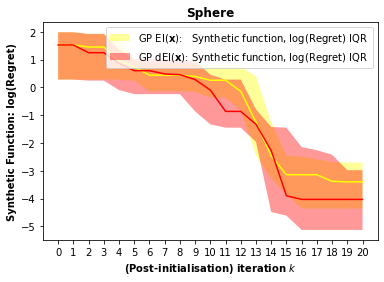

In [163]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


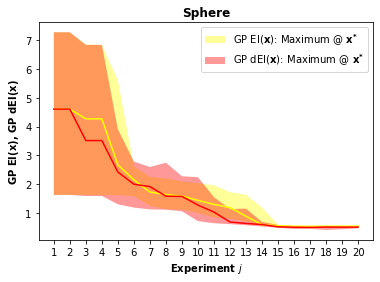

In [164]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approxAF, color = 'Yellow')
plt.plot(median_exactAF, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approxAF, upper_approxAF, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')
plt.fill_between(xstar, lower_exactAF, upper_exactAF, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$), GP dEI($\mathbf{x}$)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualise!


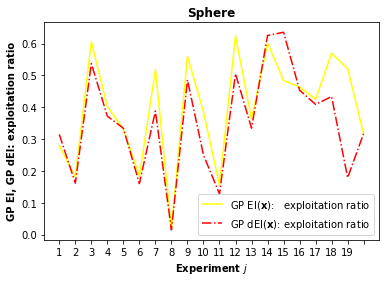

In [165]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(approx_ratio, color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio')
plt.plot(exact_ratio, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=4) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


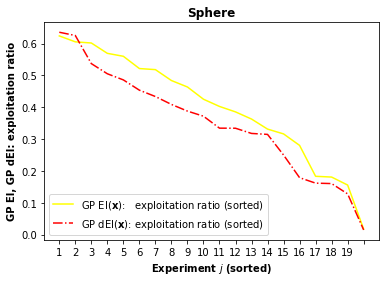

In [166]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(np.sort(approx_ratio)[::-1], color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio (sorted)')
plt.plot(np.sort(exact_ratio)[::-1], color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio (sorted)')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$ (sorted)' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


In [167]:
np.sum((approx_1.start_points_arr - exact_1.start_points_arr)**2)


0.0

In [168]:
approx_mean_test, approx_var_test = surrogate_approx_1.predict(approx_1.start_points_arr,return_std=True)
approx_std_test = np.sqrt(approx_var_test + eps)
approx_mean_test, approx_std_test


(array([-12.86424414,  -2.78650143,  -7.15623358,  -0.75505642,
         -5.40749968,  -7.60001751,  -6.12012986,  -1.28339454,
         -9.50956998,  -3.759807  , -12.70626377,  -1.27519969,
         -2.24708771,  -7.47110367,  -5.50179174,  -1.75033891,
        -15.27817355,  -4.3782639 ,  -5.14476803,  -2.90644745]),
 array([1.94573926, 1.99568657, 1.85408883, 1.72102794, 1.94829422,
        1.94003465, 1.93389915, 1.98905636, 1.91024369, 1.99620899,
        1.771973  , 1.83819853, 1.85658415, 1.94453703, 1.92781834,
        1.99722568, 1.74937049, 1.89348885, 1.8167748 , 1.99720344]))

In [169]:
exact_mean_test, exact_var_test = surrogate_exact_1.predict(exact_1.start_points_arr,return_std=True)
exact_std_test = np.sqrt(exact_var_test + eps)
np.round(exact_mean_test, 3), np.round(exact_std_test, 3)


(array([-17.699,  -4.526,  -7.071,  -1.096,  -5.627,  -8.163,  -6.596,
         -4.2  ,  -9.794,  -5.939, -12.883,  -1.596,  -1.971,  -7.376,
         -9.281,  -4.016, -15.257,  -5.244,  -3.385,  -4.388]),
 array([1.846, 1.984, 1.918, 1.748, 1.963, 1.846, 1.944, 1.946, 1.908,
        1.987, 1.785, 1.819, 1.904, 1.953, 1.881, 1.979, 1.749, 1.972,
        1.975, 1.99 ]))

In [170]:
-np.min(approx_1.f_best)

0.5462204562252847

In [171]:
-np.min(exact_1.f_best)

0.5115638210182991